# Exploration of expression data for Tabula Sapiens

**Keywords**

<ins>*Transcripts Per Million (TPM)*</ins>: The sum of ALL normalized transcript expression values is divided by 1,000,000, to create a scaling factor. Each transcript's normalized expression is divided by the scaling factor, which results in the TPM value.

<ins>*Fragments Per Kilobase of transcript per Million mapped reads (FPKM)*</ins>: Simple expression level normalization method. The FPKM normalizes read count based on gene length and the total number of mapped reads.

<ins>*Counts Per Million mapped reads (CPM)*</ins>: The number of raw reads mapped to a transcript, scaled by the number of sequencing reads in your sample, multiplied by a million. It normalizes RNA-seq data for sequencing depth but not gene length

# 1. Pre-requisites
## 1.1 Import Packages

In [1]:
import gzip
import json
import warnings

import pronto
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display
import bz2
import scanpy as sc
from scipy.stats import norm

## 1.2 Load Tabula Sapiens data

In [8]:
#load adata for Tabula Sapiens
all_cells_adata = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')

# 2. Pancreas
# 2.1 Filtering pancreas data and processing

In [4]:
#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [6]:
#processing exocrine and endocrine pancreas count data
exo_pancreas = pd.DataFrame.sparse.from_spmatrix(exo_pancreas_adata.X)
exo_pancreas = np.expm1(exo_pancreas)
exo_pancreas = exo_pancreas.sparse.to_dense()
exo_pancreas = exo_pancreas.set_axis(exo_pancreas_adata.var.index.values, axis = 1)
exo_pancreas.insert(0, 'cell_type', exo_pancreas_adata.obs['cell_ontology_class'].values)


endo_pancreas = pd.DataFrame.sparse.from_spmatrix(endo_pancreas_adata.X)
endo_pancreas = np.expm1(endo_pancreas)
endo_pancreas = endo_pancreas.sparse.to_dense()
endo_pancreas = endo_pancreas.set_axis(endo_pancreas_adata.var.index.values, axis = 1)
endo_pancreas.insert(0, 'cell_type', endo_pancreas_adata.obs['cell_ontology_class'].values)

In [7]:
print(f'Exocrine pancreas has {len(exo_pancreas)} cells. Endocrine pancreas has {len(endo_pancreas)} cells.')

Exocrine pancreas has 11977 cells. Endocrine pancreas has 1520 cells.


## 2.2 Plot boxplots of insulin expression across cell types in endocrine and exocrine pancreas
### 2.2.1 Endocrine pancreas

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

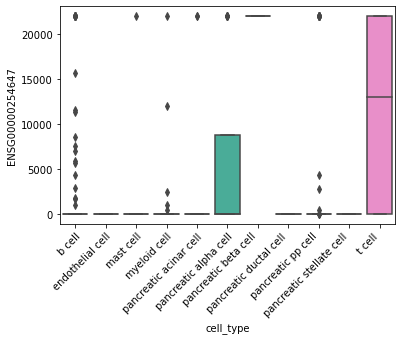

In [145]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = endo_pancreas, x = 'cell_type', y = 'ENSG00000254647')

### 2.2.2 Exocrine pancreas

<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

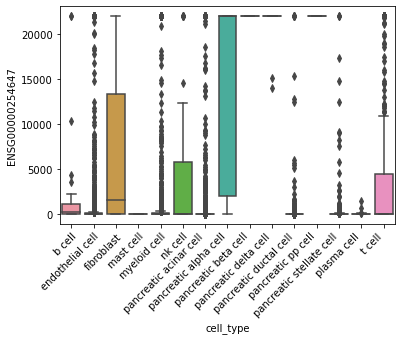

In [146]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = exo_pancreas, x = 'cell_type', y = 'ENSG00000254647')

## 2.3 Plot insulin expression distribution across all cells in the endocrine and exocrine pancreas
### 2.3.1 Endocrine pancreas

<AxesSubplot:ylabel='Frequency'>

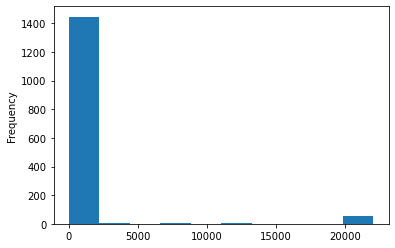

In [156]:
endo_pancreas['ENSG00000254647'].plot.hist()

In [167]:
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] > 15000].unique()

array([22025.465, 15697.833], dtype=float32)

What is bizarre, is that there are 57 cells with the same expression of 22025.465 CPM.

In [170]:
endo_pancreas[endo_pancreas['ENSG00000254647'] == 22025.465]

cell_type  ENSG00000223972  ENSG00000227232  \
897                   t cell              0.0         0.000000   
898                   t cell              0.0         0.000000   
899                   b cell              0.0         0.000000   
901                   b cell              0.0         0.000000   
903                mast cell              0.0         0.000000   
904                   t cell              0.0         0.000000   
905                   b cell              0.0         0.000000   
906     pancreatic beta cell              0.0         0.000000   
909                   b cell              0.0         0.000000   
914                   t cell              0.0         0.000000   
915                   b cell              0.0         0.000000   
916    pancreatic alpha cell              0.0         0.000000   
917                   t cell              0.0         0.000000   
918                   b cell              0.0         0.000000   
925                   t cell              0.0         0.000000   
926                   t cell              0.0         0.000000   
927                   t cell              0.0         0.000000   
929       pancreatic pp cell              0.0         0.000000   
930                   b cell              0.0         0.000000   
934                   b cell              0.0         0.000000   
938                   t cell              0.0         0.000000   
939                   t cell              0.0         0.000000   
940                   b cell              0.0         0.000000   
941                   t cell              0.0         0.000000   
943     pancreatic beta cell              0.0         0.000000   
947                   t cell              0.0         0.000000   
948             myeloid cell              0.0         0.000000   
950                   b cell              0.0         0.000000   
952                   b cell              0.0         0.000000   
956                   t cell              0.0         0.000000   
957                   t cell              0.0         0.000000   
960   pancreatic acinar cell              0.0         0.000000   
964       pancreatic pp cell              0.0         0.000000   
965       pancreatic pp cell              0.0         0.000000   
974    pancreatic alpha cell              0.0         0.000000   
975    pancreatic alpha cell              0.0         4.484884   
982       pancreatic pp cell              0.0         0.000000   
1007      pancreatic pp cell              0.0         0.000000   
1020      pancreatic pp cell              0.0         3.283116   
1022    pancreatic beta cell              0.0         0.000000   
1027  pancreatic acinar cell              0.0         0.000000   
1029    pancreatic beta cell              0.0         0.000000   
1030    pancreatic beta cell              0.0         0.000000   
1031      pancreatic pp cell              0.0         0.000000   
1032      pancreatic pp cell              0.0         0.000000   
1040      pancreatic pp cell              0.0         0.000000   
1041      pancreatic pp cell              0.0         0.000000   
1042   pancreatic alpha cell              0.0         0.000000   
1053    pancreatic beta cell              0.0         0.000000   
1057    pancreatic beta cell              0.0         0.000000   
1059    pancreatic beta cell              0.0         0.000000   
1062    pancreatic beta cell              0.0         0.000000   
1065      pancreatic pp cell              0.0         0.132462   
1066    pancreatic beta cell              0.0         0.000000   
1073    pancreatic beta cell              0.0         0.000000   
1078   pancreatic alpha cell              0.0         0.000000   
1079   pancreatic alpha cell              0.0         0.000000   

      ENSG00000278267  ENSG00000243485  ENSG00000284332  ENSG00000237613  \
897          0.000000              0.0              0.0              0.0   
898          0.000000              0.0

These 57 cells however are not all the same cell type making it unlikely they are all duplicates. This could be due to technical errors in the limitation of detection of the read counts and when normalising and scaling they reduced the real read counts which were higher to a lower value?

In [178]:
endo_pancreas['ENSG00000254647'][(endo_pancreas['ENSG00000254647'] >4000 ) & (endo_pancreas['ENSG00000254647'] < 15000)].sort_values()

945      4007.911865
932      4322.045898
997      4356.529785
913      5615.633301
902      5843.714844
954      6966.125488
900      7558.000977
924      8545.727539
1068     8804.474609
911     11334.809570
936     11523.946289
923     12024.778320
Name: ENSG00000254647, dtype: float32

<AxesSubplot:ylabel='Frequency'>

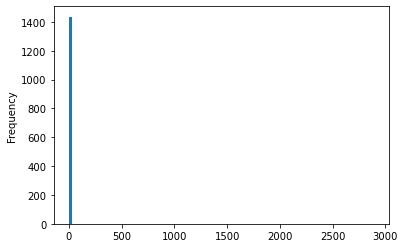

In [184]:
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] <= 4000].plot.hist(bins = 100)

Below, 4000 CPM nearly all the counts are 0 CPM for insulin.

**Ignoring the massive amount of zero counts**

<AxesSubplot:ylabel='Frequency'>

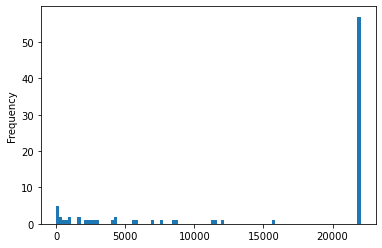

In [188]:
endo_pancreas['ENSG00000254647'][endo_pancreas['ENSG00000254647'] > 0].plot.hist(bins = 100)

### 2.3.2 Exocrine pancreas

<AxesSubplot:ylabel='Frequency'>

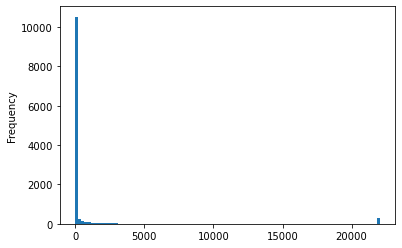

In [152]:
exo_pancreas['ENSG00000254647'].plot.hist(bins = 100)

<AxesSubplot:ylabel='Frequency'>

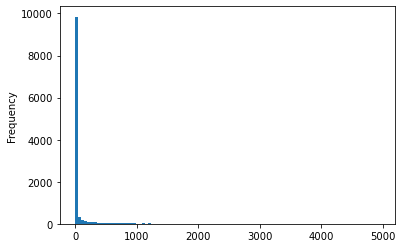

In [187]:
exo_pancreas['ENSG00000254647'][exo_pancreas['ENSG00000254647'] < 5000].plot.hist(bins = 100)

**Ignoring the massive amount of zero counts**

<AxesSubplot:ylabel='Frequency'>

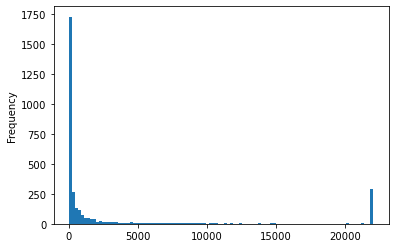

In [189]:
exo_pancreas['ENSG00000254647'][exo_pancreas['ENSG00000254647'] > 0].plot.hist(bins = 100)

Even removing the zero counts still produces a distribution that has a high number of counts around the zero mark.

## 2.4 Plot insulin expression distribution across cells for pancreas (cell type coloured)
### 2.4.1 Endocrine pancreas

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

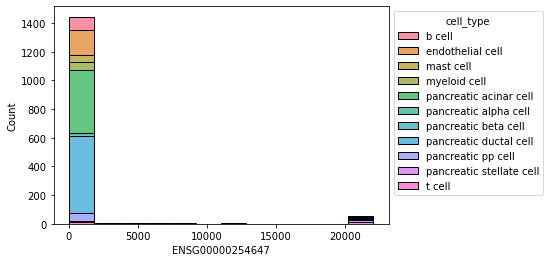

In [28]:
ax = sns.histplot(data = endo_pancreas, x = 'ENSG00000254647', hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

This shows the number of cells in a cell type with the expression count for insulin. Here we see the expression is dominated by zero so what does it look like if we remove it.

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

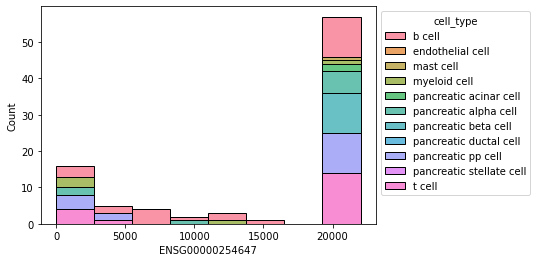

In [29]:
ax = sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', hue = 'cell_type',
                  multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Removing the zero expression values reveal populations of cells of different cell types with a near zero expression and a large group of cell types with a high insulin expression (namely b cells, t cells, pancreatic beta cells, pancreatic pp cells and alpha cells) as shown by the stacked boxes. 

By removing the zero expression we can also log tranform the scale to see that the majority of expressions above the zero count have a magnitude in the thousands/tens of thousands.

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='ENSG00000254647', ylabel='Count'>

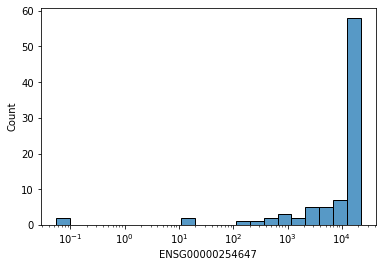

In [31]:
sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True)

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

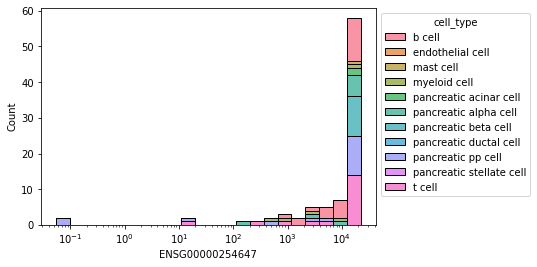

In [33]:
ax = sns.histplot(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True, 
             hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Again we see that the higher expressions fall across most cell types and does not appear to be exclusive to just one.

### 2.4.2 Exocrine pancreas

**Remove zero counts to see expressions better**

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

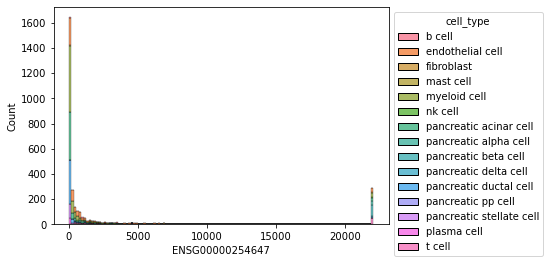

In [41]:
ax = sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', hue = 'cell_type',
                  multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

The histogram above shows that the majority of cells have an expression close to zero but some cell types exhibit a high expression however, this is not as significant as the smaller expressions.

**Log scale the expression axis to see histogram better**

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass ob

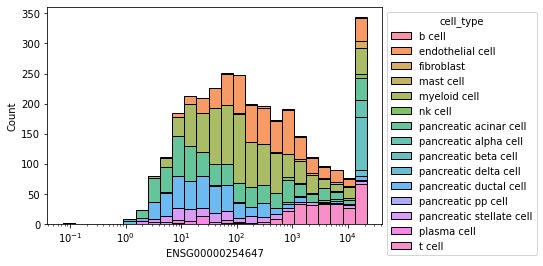

In [47]:
ax = sns.histplot(data = exo_pancreas[exo_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', log_scale = True, 
             hue = 'cell_type', multiple = 'stack')

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

This shows that apart from the highest expression of the insulin and zero counts the expression follows a roughly normal distribution over all cells however, the individual cell types have different distributions.

Does this mean it would be best to choose an average metric based on the log scaled counts of the data points????? But again this distribution is across all cell types in the pancreas so basically taken as bulk not single-cell.

## 2.5 Plot insulin expression distribution across cells within pancreas cell types

### 2.5.1 Endocrine pancreas

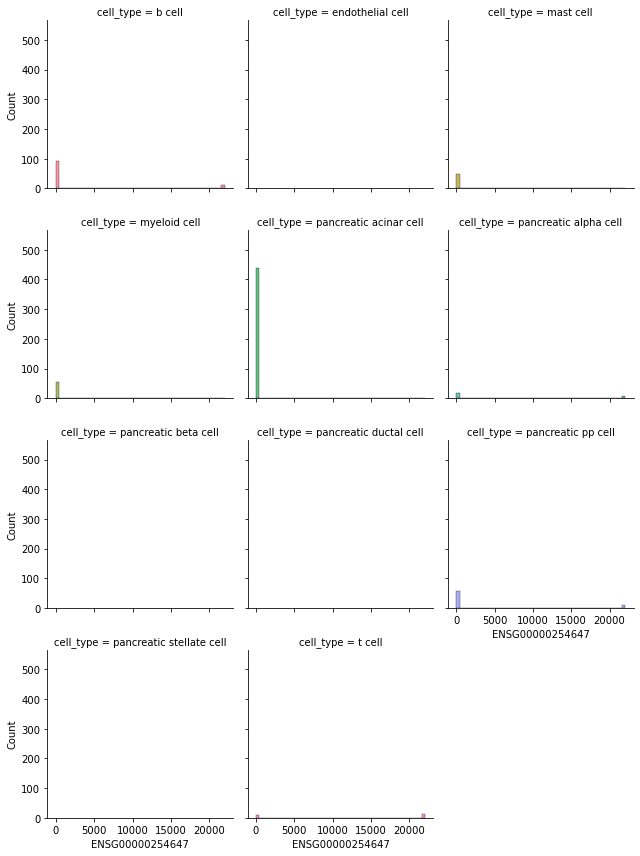

In [59]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

g = sns.FacetGrid(data = endo_pancreas, col = 'cell_type', col_wrap = 3, hue = 'cell_type')
g.map_dataframe(sns.histplot, x = 'ENSG00000254647', bins = 50)

**Remove zero expression counts as these are overshadowing the other counts**

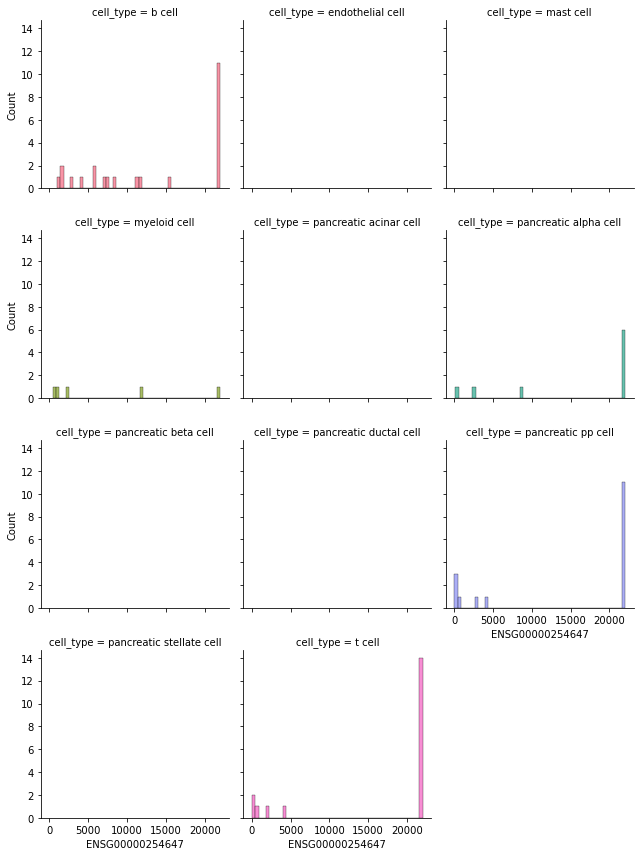

In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

g = sns.FacetGrid(data = endo_pancreas[endo_pancreas['ENSG00000254647'] > 0], col = 'cell_type', col_wrap = 3, hue = 'cell_type')
g.map_dataframe(sns.histplot, x = 'ENSG00000254647', bins = 50)

**Still there appears to be overshadowing of some cells expressions so will use separate plots**

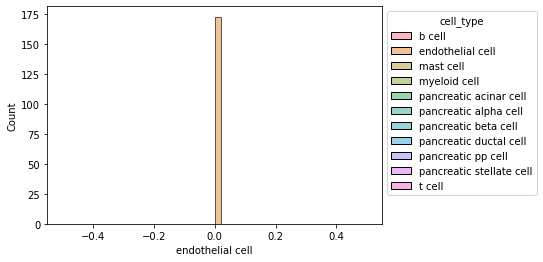

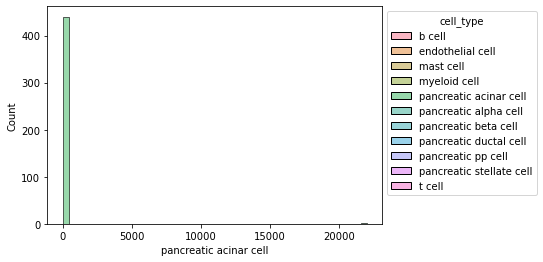

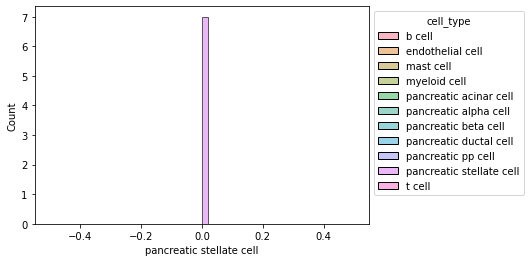

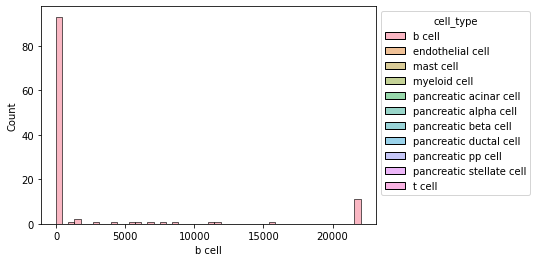

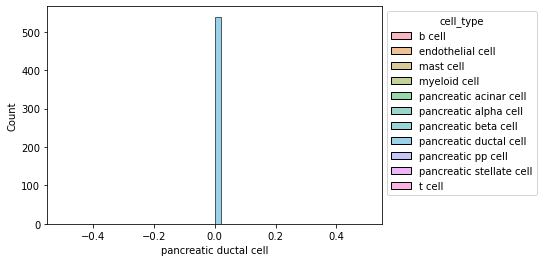

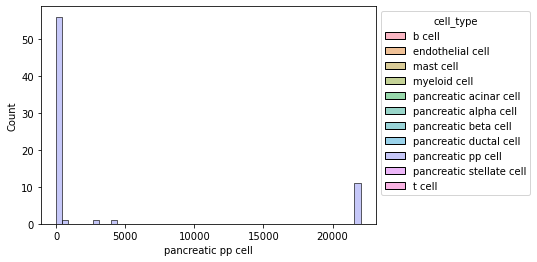

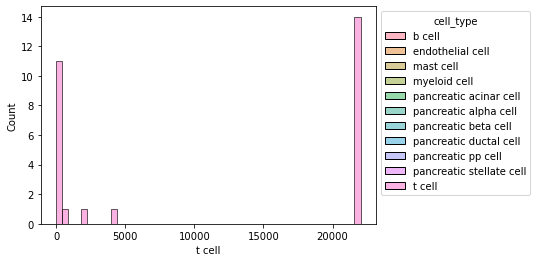

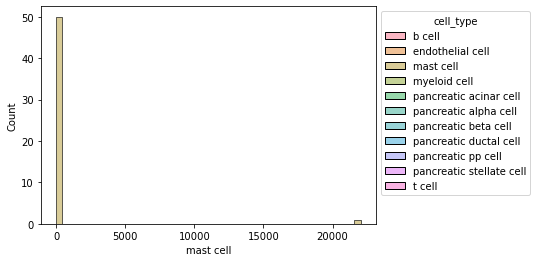

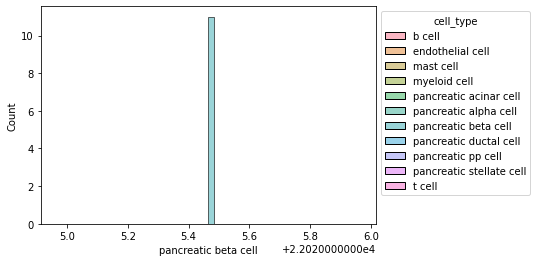

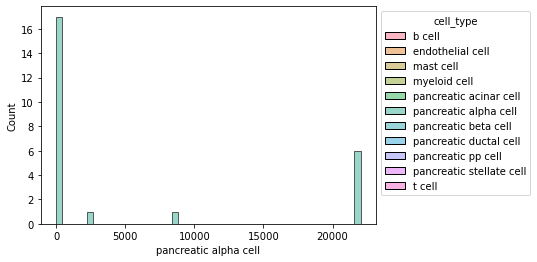

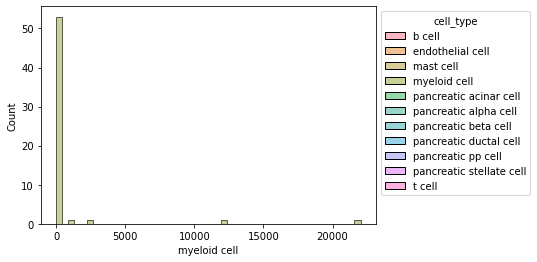

In [74]:
for i in endo_pancreas.cell_type.unique():
    ax = sns.histplot(data = endo_pancreas[endo_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 50, hue = 'cell_type')
    #move figure legend outside of the plot
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.xlabel(i)
    plt.show()

We see that endothelial cells, and pancreatic ductal and stellate cells only have zero expression for insulin gene. The others appear to have cells with high zero expressions but some cells with a non-zero expression too.

### 2.5.2 Exocrine pancreas

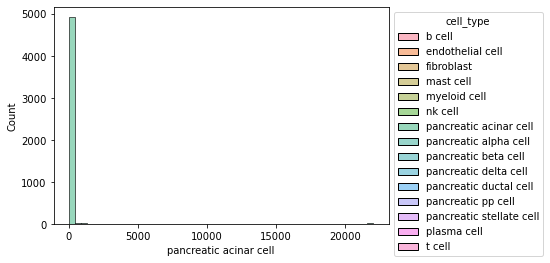

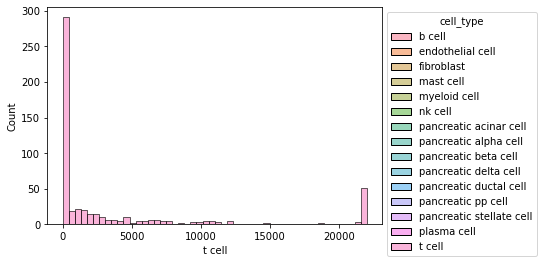

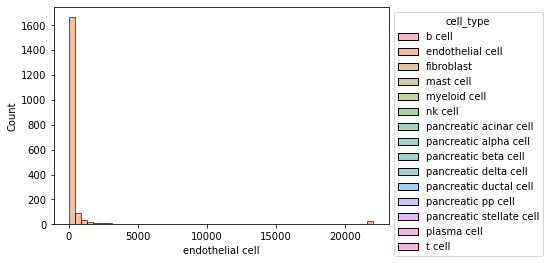

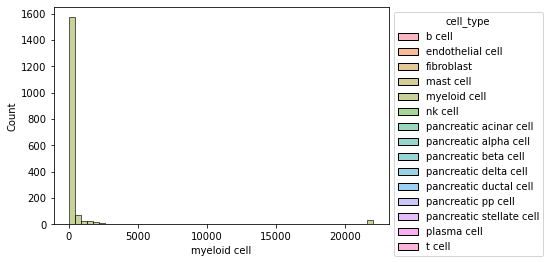

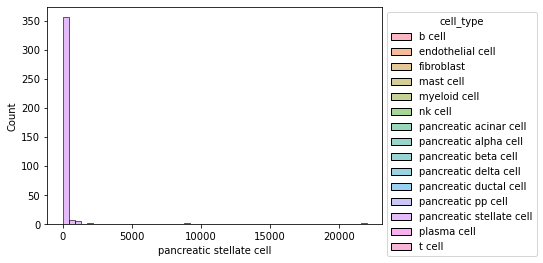

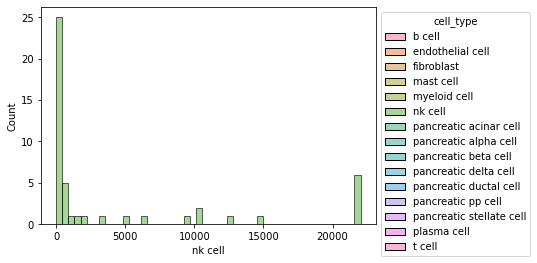

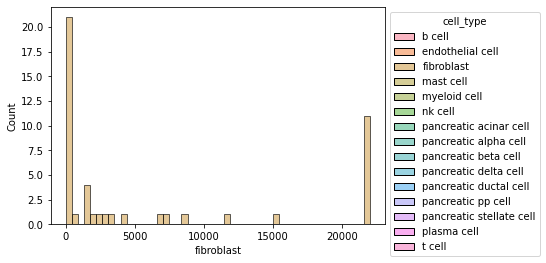

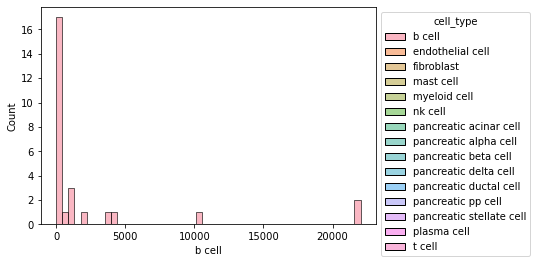

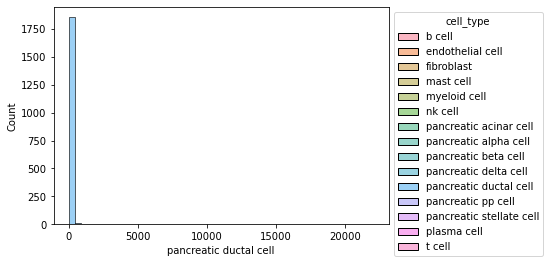

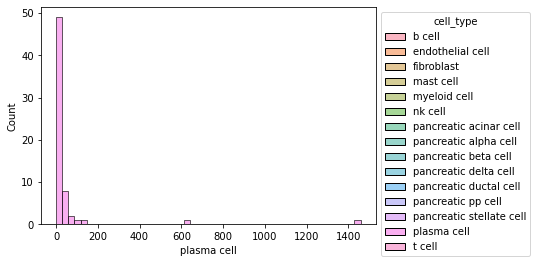

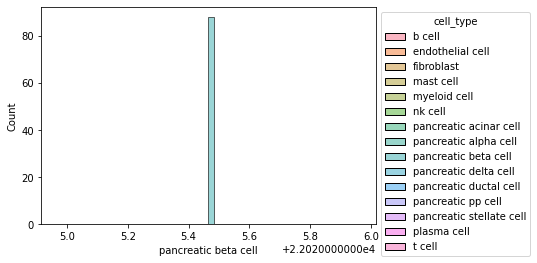

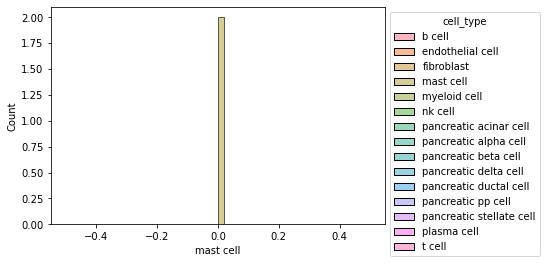

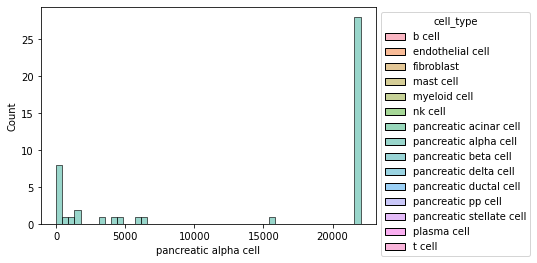

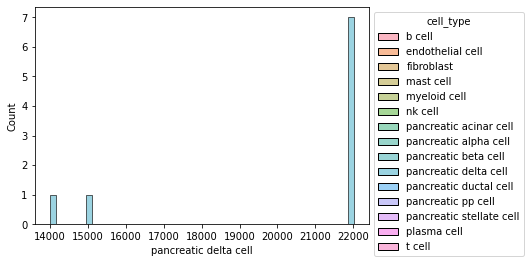

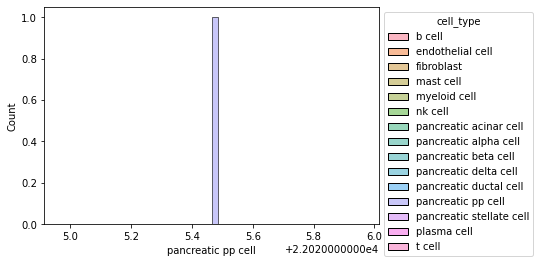

In [85]:
for i in exo_pancreas.cell_type.unique():
    ax = sns.histplot(data = exo_pancreas[exo_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 50, hue = 'cell_type')
    #move figure legend outside of the plot
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.xlabel(i)
    plt.show()

The islets of Langerhans where we expect insulin secretion in the pancreas consists of alpha, beta, delta and pp cells; it is known that the beta cells secrete insulin so this could be inaccurate sorting of cells that we're seeing resulting in other cell types from the islets of Langerhans to appear to have high insulin expression.

# 3. What about the data when the pancreas is considered as a whole?
## 3.1 Read in total pancreas dataset

In [2]:
total_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

In [4]:
print(f'The whole pancreas has {len(total_pancreas)} cells.')

The whole pancreas has 13497 cells.


## 3.2 Insulin expression across cell types
### 3.2.1 Boxplots

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

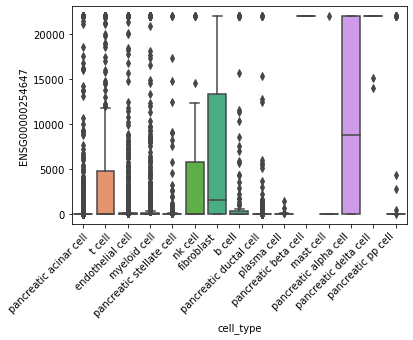

In [5]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = total_pancreas, x = 'cell_type', y = 'ENSG00000254647')

Most cell types don't have enough information to produce boxplots for insulin expression perhaps because the amount of zero counts in the data overwhelms the other data points.

**Remove zero expression data points**

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot:xlabel='cell_type', ylabel='ENSG00000254647'>

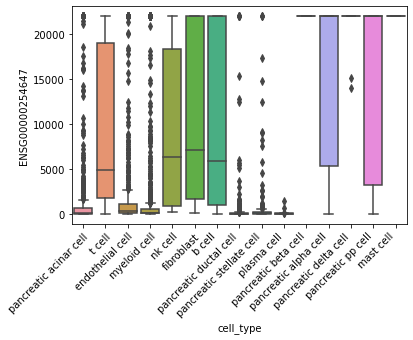

In [6]:
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = total_pancreas[total_pancreas['ENSG00000254647'] > 0], x = 'cell_type', y = 'ENSG00000254647')

Removing the zero counts enables us to see better the distribution of expression values across the cell types which previosuly we could not.

### 3.2.2 Histogram

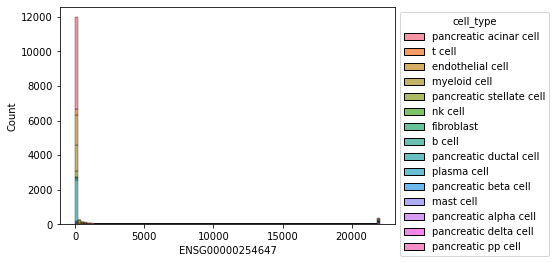

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ax = sns.histplot(data = total_pancreas, x = 'ENSG00000254647', bins = 100, hue = 'cell_type', multiple = 'stack')
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

Again the non-zero expression counts are being overwhelmed by the amount of zero expression cells so removing these will help us to see what the distribution of the other counts are.

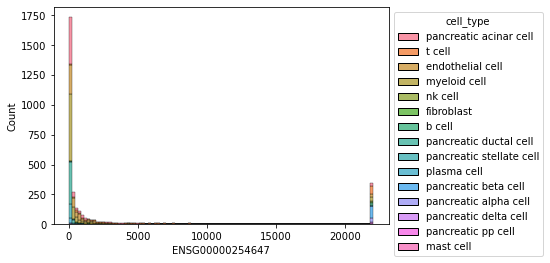

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

ax = sns.histplot(data = total_pancreas[total_pancreas['ENSG00000254647'] > 0], x = 'ENSG00000254647', bins = 100, 
                  hue = 'cell_type', multiple = 'stack')
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

We see that even when we remove the zero expression counts we still have low expression counts which dominate the distribution potentially meaning that removing the EXACT zero counts does detrimentally alter the dsitribution of expression counts but allows other smaller populations to become apparent like the clustering of cells of different cell types with expressions exceeding 20,000 which are still potentially significant.

**NOW, I want to plot the distribution of expressions for each cell type on separate axes to zoom in on their distributions**

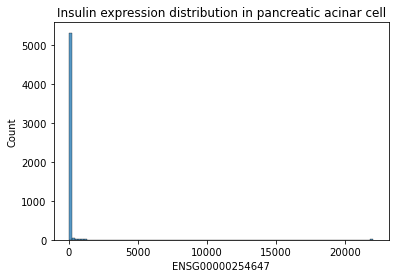

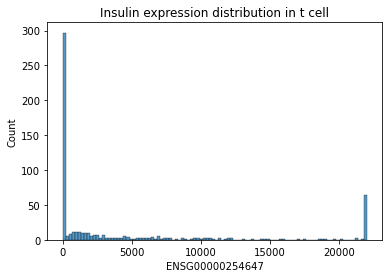

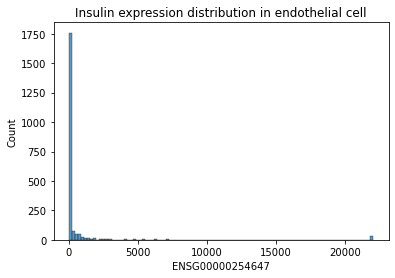

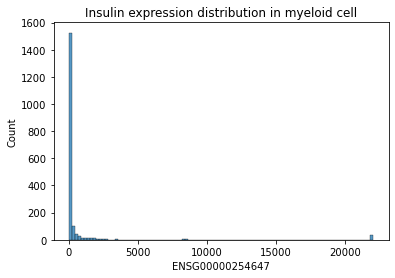

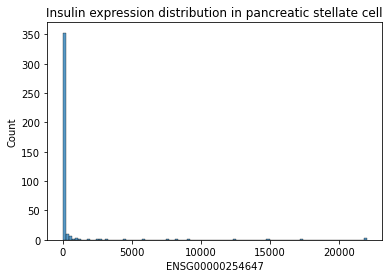

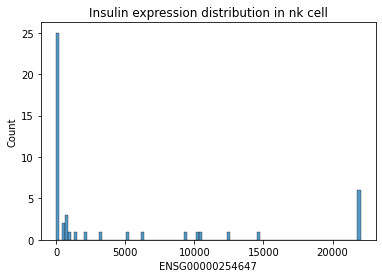

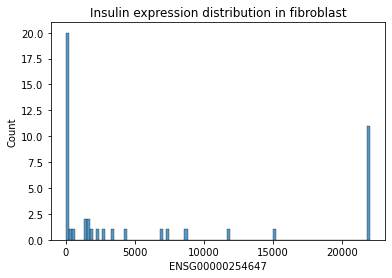

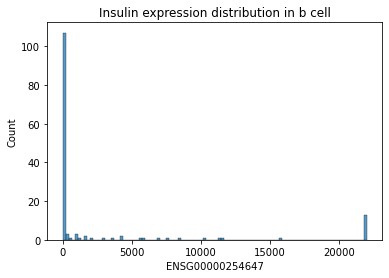

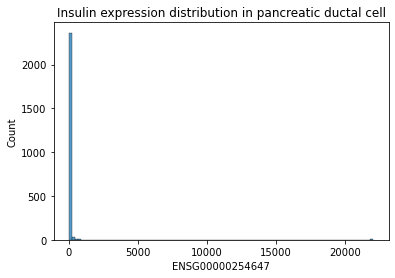

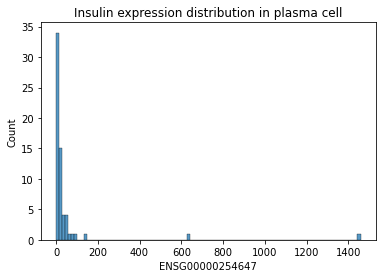

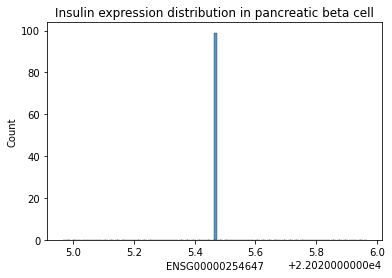

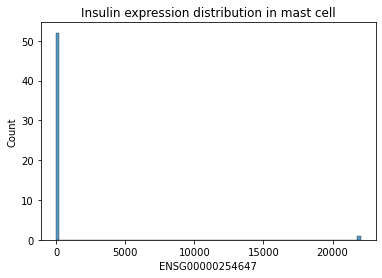

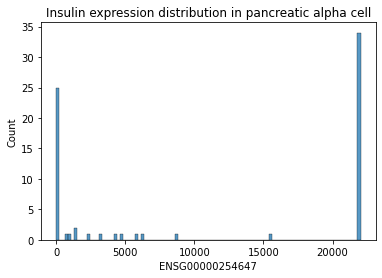

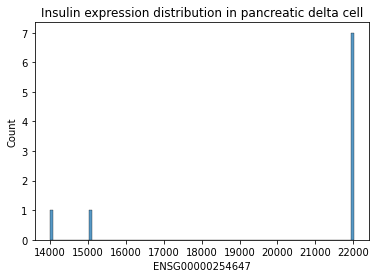

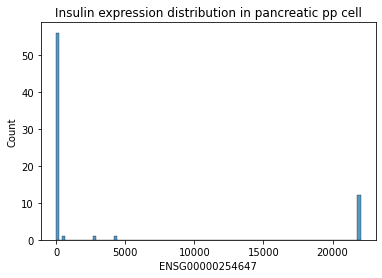

In [19]:
for i in total_pancreas.cell_type.unique():
    ax = sns.histplot(data = total_pancreas[total_pancreas.cell_type == i], x = 'ENSG00000254647', bins = 100)
    plt.title(f'Insulin expression distribution in {i}')
    plt.show()

**Removing the zero count expressions**

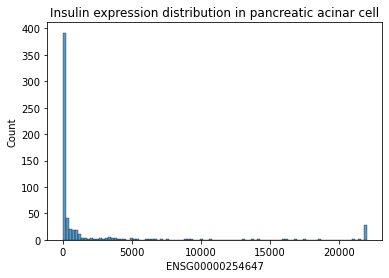

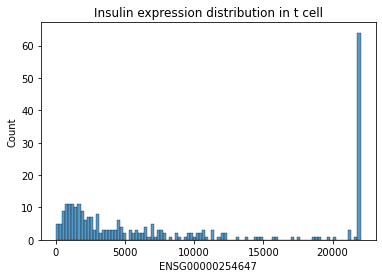

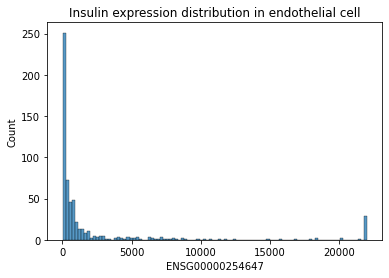

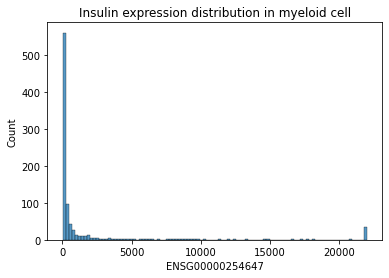

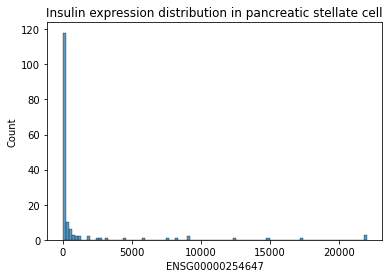

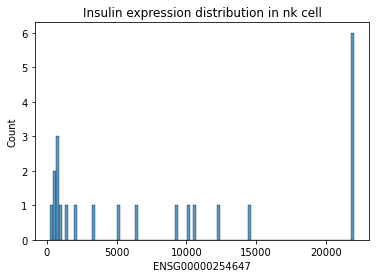

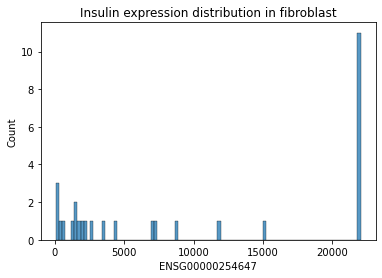

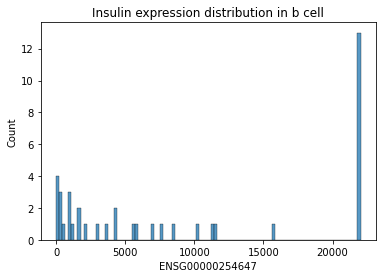

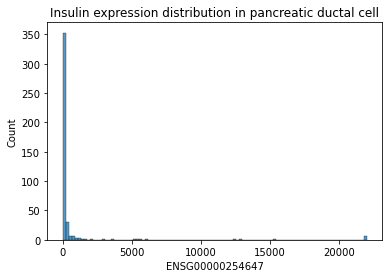

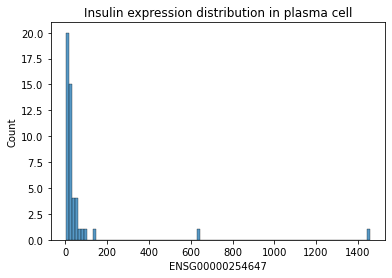

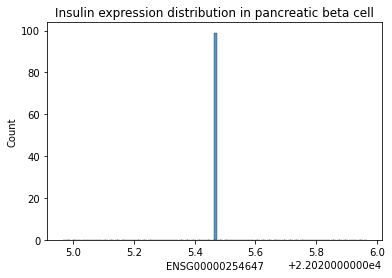

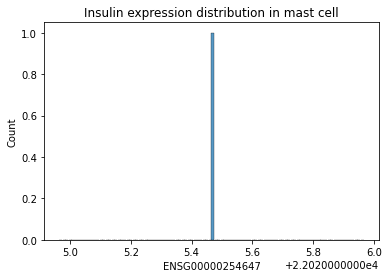

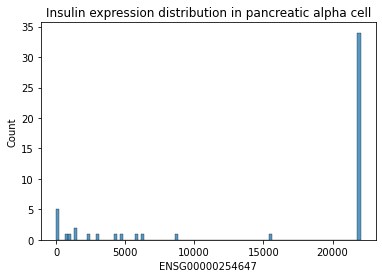

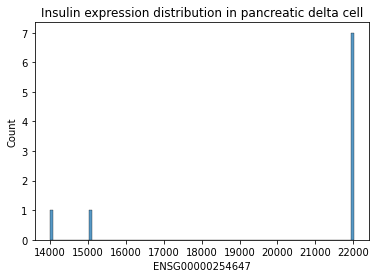

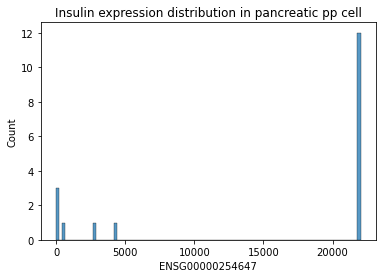

In [20]:
non_zero_filtered = total_pancreas[total_pancreas['ENSG00000254647'] > 0]

for i in total_pancreas.cell_type.unique():
    ax = sns.histplot(data = non_zero_filtered[non_zero_filtered.cell_type == i], x = 'ENSG00000254647', bins = 100)
    plt.title(f'Insulin expression distribution in {i}')
    plt.show()

Getting rid of the zero counts makes cell types like nk cells, fibroblasts and b cells appear to have a population of some cells with a high expression of insulin which is not expected as the gene is almost exclusively expressed in pancreatic beta cells.

Should we consider an expression threshold minimum before considering it as expressed??????????? The pancreatic beta cells have 100 cells with roughly the same expression of ~22,000, this number of cells expressing the transcript is higher than any other cell type but it is not the biggest expression seen as we see this value also in other pancreatic islet of langerhans cell types but in a smaller number of cells.

In [24]:
median_pancreas = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')

In [26]:
pd.DataFrame(median_pancreas['ENSG00000254647'])

ENSG00000254647
cell_type                                
b cell                           0.000000
endothelial cell                 0.000000
fibroblast                    1506.253906
mast cell                        0.000000
myeloid cell                     0.000000
nk cell                          0.000000
pancreatic acinar cell           0.000000
pancreatic alpha cell         8804.474609
pancreatic beta cell         22025.464844
pancreatic delta cell        22025.464844
pancreatic ductal cell           0.000000
pancreatic pp cell               0.000000
pancreatic stellate cell         0.000000
plasma cell                      7.536572
t cell                           0.000000

These median values compared to the expression distributions show that the cell types with a limited number of cells annotated as the cell type show that this is where the contradictory expression median values appear to be coming from. It is a result of not enough cells being sampled for the cell type resulting in a significant number of cells registering erroneous expression values e.g. plasma cell where there are 20 cells with zero counts but the few cells with higher counts that may be abnormalities in the data due to technical errors produce a median expression that is not representative of the actual expression counts for the majority of cells. Therefore, a threshold for the number of cells may need to be considered to accurately produce a median expression value.

# 4. GAPDH expression across all cell types within a tissue
## 4.1 Lung
### 4.1.1 Filter out lung cells counts

In [3]:
#filter out lung cells
lung = all_cells_adata[all_cells_adata.obs.tissue_ontology_term_id == 'UBERON:0002048']

#convert sparse matrix to dense matrix and exponentiate expression values
lung_counts = pd.DataFrame.sparse.from_spmatrix(lung.X)
lung_counts = np.expm1(lung_counts)
lung_counts = lung_counts.sparse.to_dense()

#add gene names to the columns
gene_names = lung.var.index.values
lung_counts = lung_counts.set_axis(gene_names, axis = 1)

#add cell type
cell_type = lung.obs['cell_ontology_class'].values
lung_counts.insert(0, 'cell_type', cell_type)

lung_counts = lung_counts.drop(lung_counts.columns[(lung_counts == 0).all()], axis = 1)

#save dataframe
lung_counts.to_pickle('lung_counts.pkl', compression = 'gzip')

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


### 4.1.2 Plot GAPDH expression across all lung cells

**Boxplot**

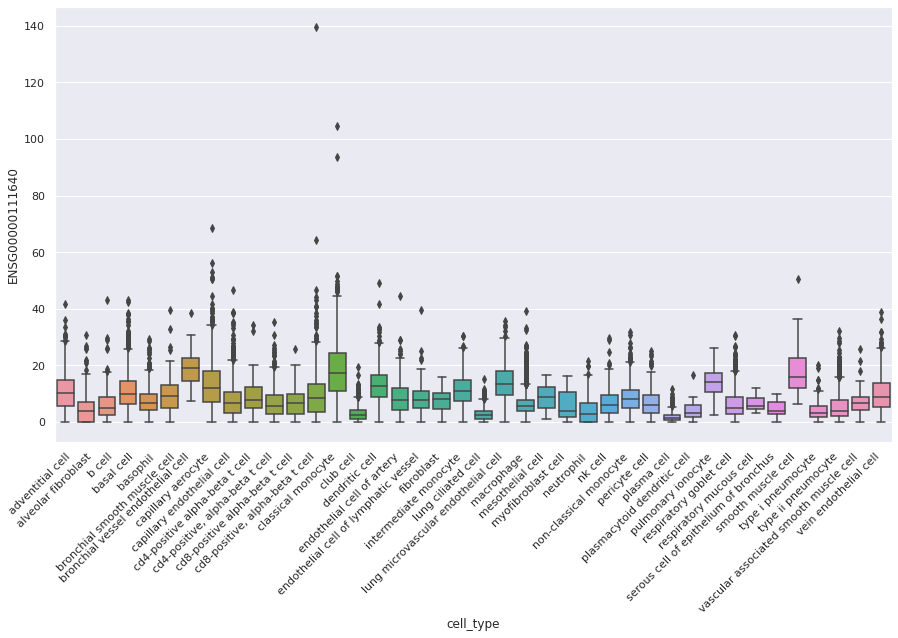

In [46]:
#boxplot of GADPH expression across all cells grouped by cell type
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = lung_counts, x = 'cell_type', y = 'ENSG00000111640')
sns.set(rc={'figure.figsize':(10,8)})

In [54]:
median_tabula = pd.read_pickle('median_exp_tabula_counts_uberon_ensemblid.pkl', compression = 'gzip')
median_lung_counts = median_tabula.loc['UBERON:0002048']

#median GADPH expression counts for each cell type
median_lung_counts['ENSG00000111640']

cell_type
adventitial cell                          10.203913
alveolar fibroblast                        3.827527
b cell                                     5.064534
basal cell                                 9.855150
basophil                                   6.664721
bronchial smooth muscle cell               9.289935
bronchial vessel endothelial cell         19.245228
capillary aerocyte                        11.906199
capillary endothelial cell                 6.626226
cd4-positive alpha-beta t cell             7.814285
cd4-positive, alpha-beta t cell            5.594961
cd8-positive alpha-beta t cell             6.582016
cd8-positive, alpha-beta t cell            8.491459
classical monocyte                        17.277014
club cell                                  2.639184
dendritic cell                            12.618114
endothelial cell of artery                 7.676679
endothelial cell of lymphatic vessel       7.701443
fibroblast                                 8.229611
in

**Histogram**

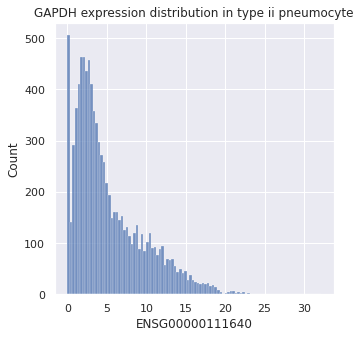

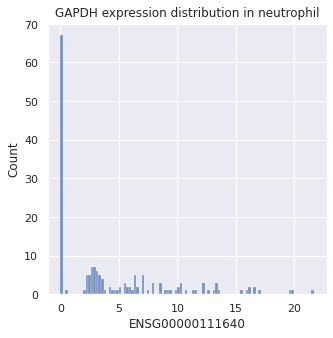

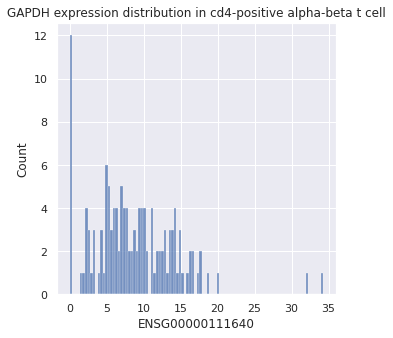

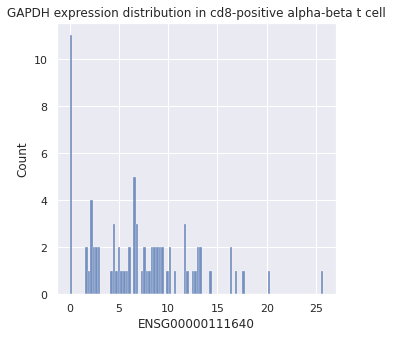

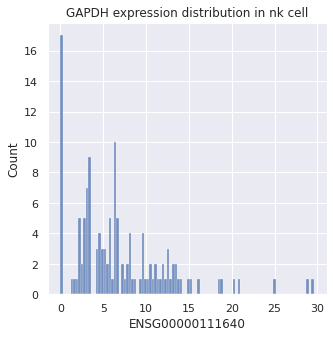

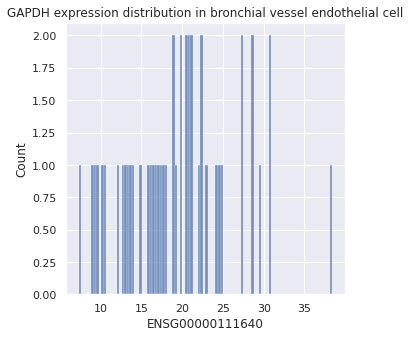

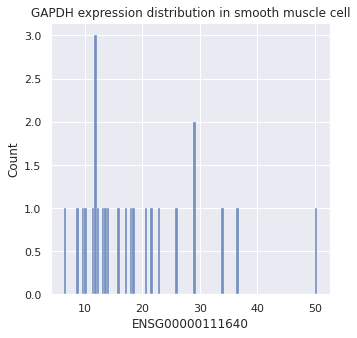

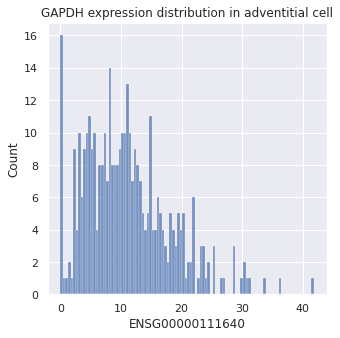

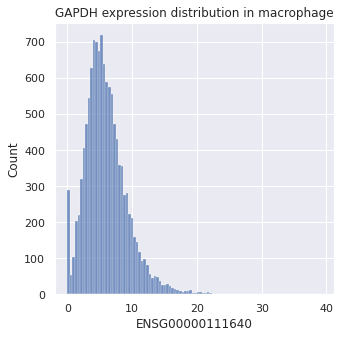

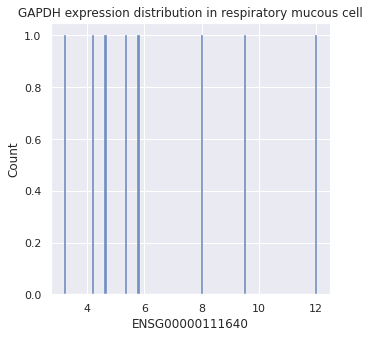

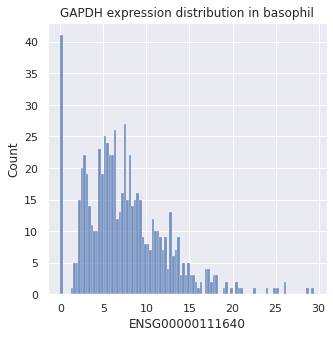

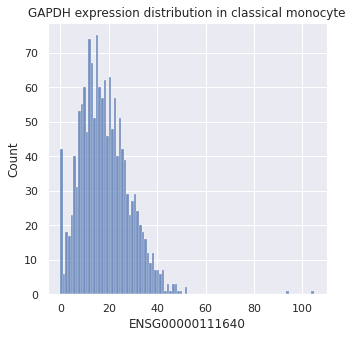

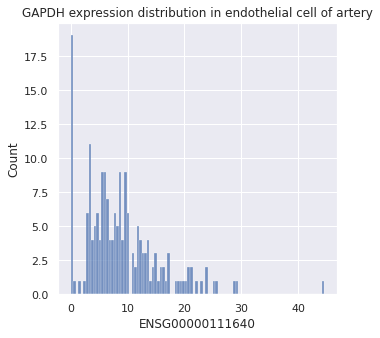

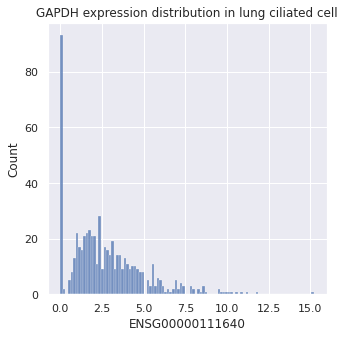

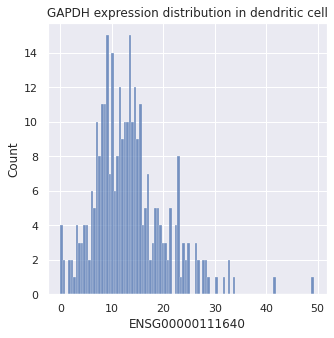

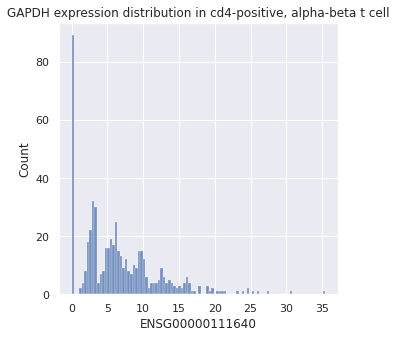

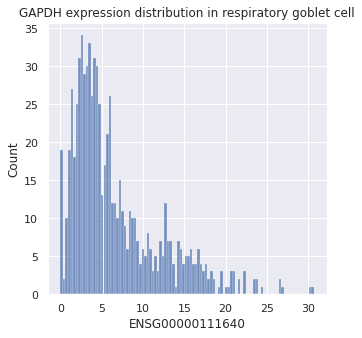

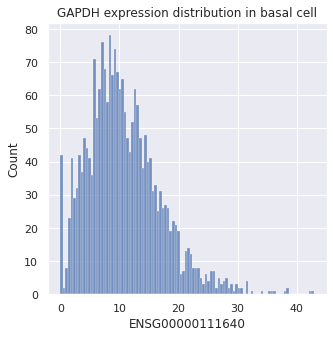

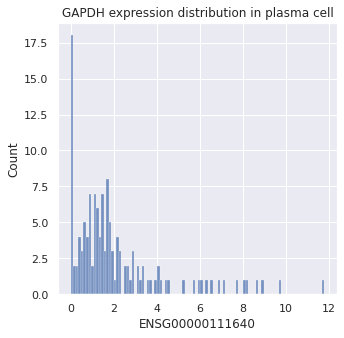

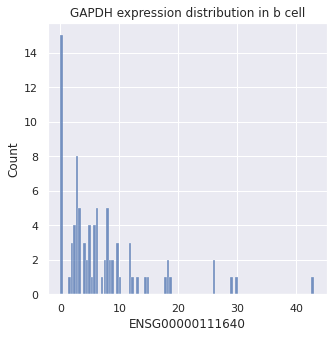

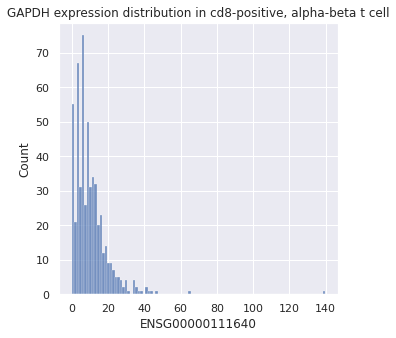

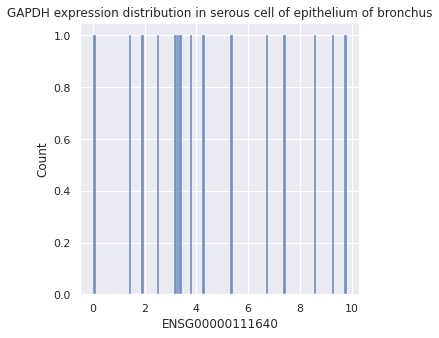

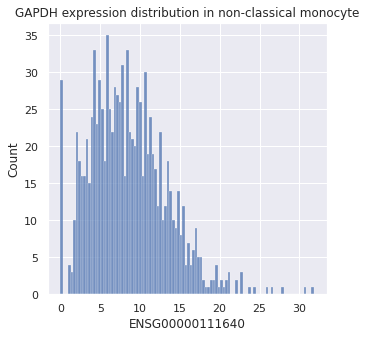

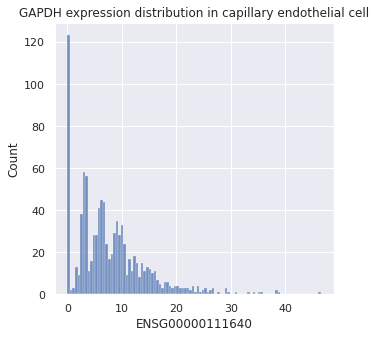

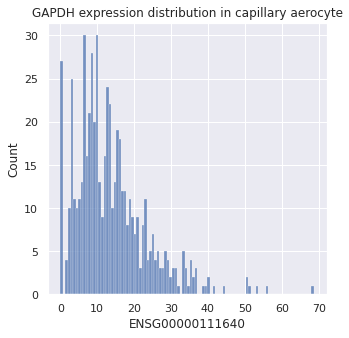

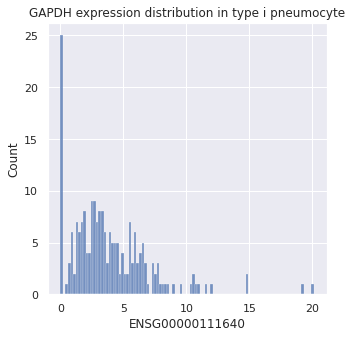

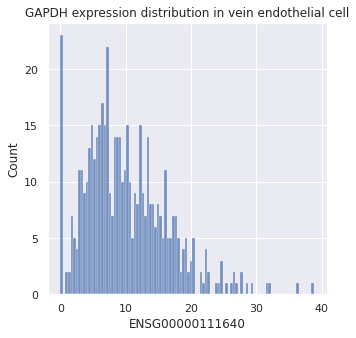

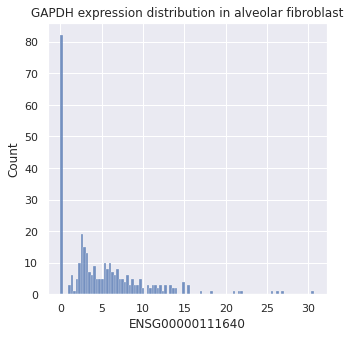

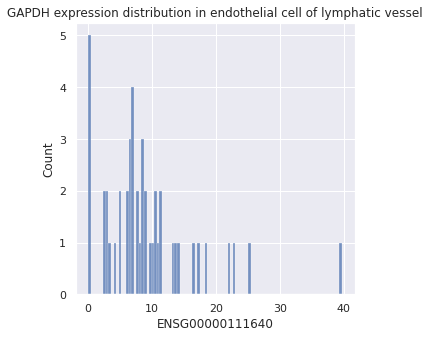

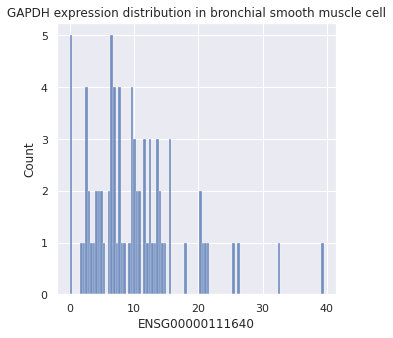

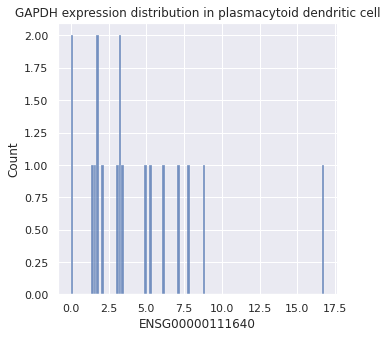

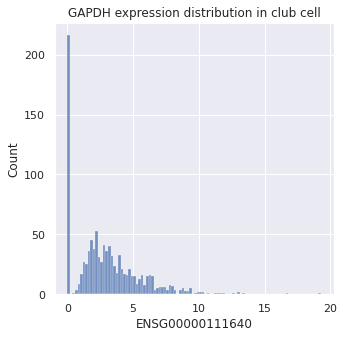

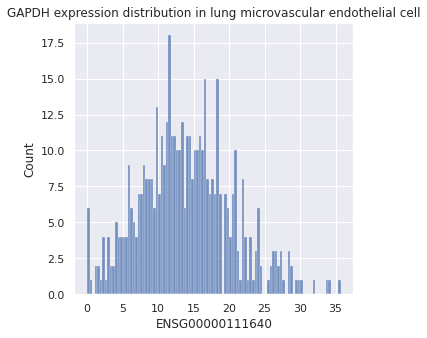

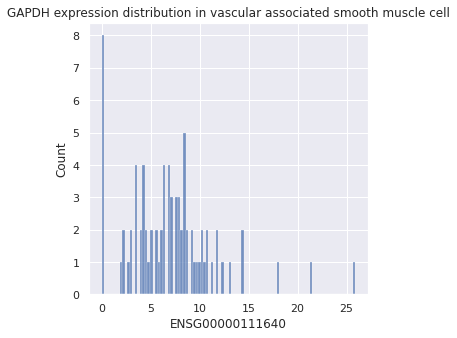

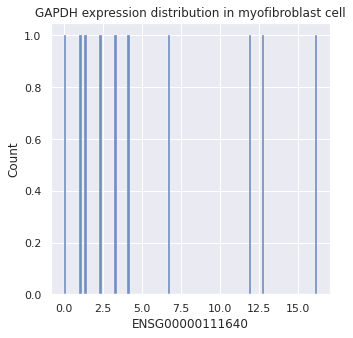

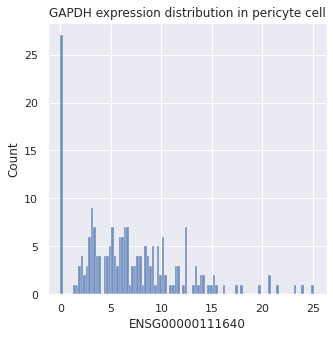

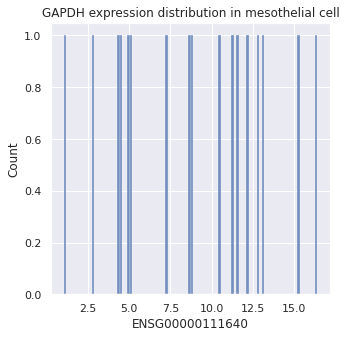

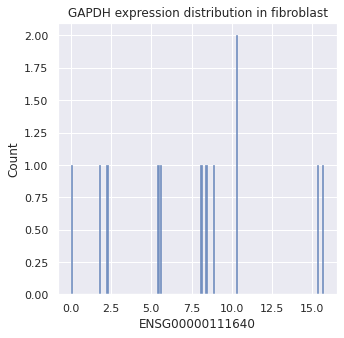

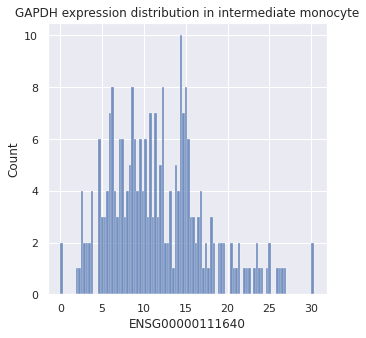

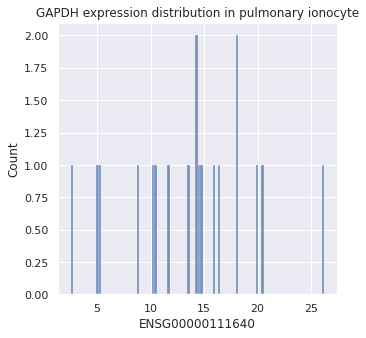

In [58]:
sns.set(rc={'figure.figsize':(5,5)})

for i in lung_counts.cell_type.unique():
    ax = sns.histplot(data = lung_counts[lung_counts.cell_type == i], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression distribution in {i}')
    plt.show()

Could a possibility be to filter out cells that have a zero expression of housekeeping genes in order to roughly get rid of cells that could have erroneous expression values??????????????

**Cells with a zero GAPDH expression in the lungs do they correspond to cells which "express" highly specific genes found elsewhere**

In [73]:
#find cells with a zero expression of housekeeping gene GAPDH
GAPDH_zero = lung_counts[lung_counts['ENSG00000111640'] == 0]

#create dataframe for insulin expression count of cells with GADPH count of zero
df = pd.DataFrame(GAPDH_zero[['cell_type','ENSG00000254647']])

#filter df for cells with non-zero insulin expression but zero GAPDH expression
df[df.ENSG00000254647 != 0]

cell_type  ENSG00000254647
11991  type ii pneumocyte        41.587708

The answer here is yes for one of the cells. Let's see what other cell types had a non-zero expression for insulin and what their corresponding GAPDH (ENSG00000111640) expression was:

In [76]:
##find cells with a non-zero expression of highly specific gene insulin
insulin_non_zero = lung_counts[lung_counts['ENSG00000254647'] != 0]

#create dataframe for GAPDH expression count of cells with non-zero insulin expression
df = pd.DataFrame(insulin_non_zero[['cell_type', 'ENSG00000254647', 'ENSG00000111640']])
df

cell_type  ENSG00000254647  ENSG00000111640
8566                        macrophage        22.681904         4.306696
8754                classical monocyte     22025.464844        21.992468
9543                        macrophage         7.217002         5.572401
9957                        macrophage        27.267170         9.029792
10052                         basophil      2126.052002         7.437006
10425  cd4-positive, alpha-beta t cell     20341.980469        11.583733
11633                       macrophage        26.226860         8.365513
11991               type ii pneumocyte        41.587708         0.000000
13295                       macrophage        18.712683         1.532750
16348                       macrophage        18.352549         7.806400

In [78]:
df.cell_type.unique().tolist()

['macrophage',
 'classical monocyte',
 'basophil',
 'cd4-positive, alpha-beta t cell',
 'type ii pneumocyte']

This doesn't really tell me much since GAPDH expression has a normal distribution over 0-40 CPM for cells within each of these cell types.

<AxesSubplot:xlabel='ENSG00000111640', ylabel='Count'>

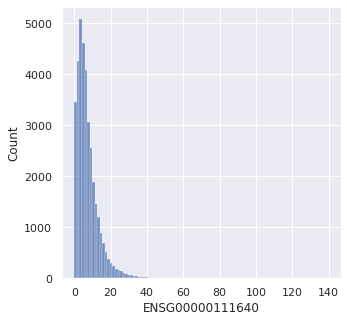

In [79]:
sns.histplot(data = lung_counts, x = 'ENSG00000111640', bins = 100)

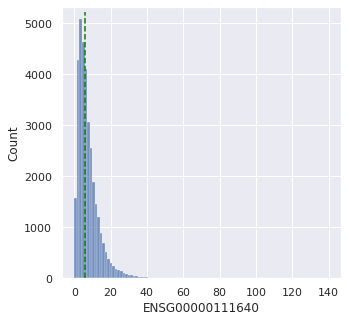

In [95]:
ax = sns.histplot(data = lung_counts[lung_counts['ENSG00000111640'] > 0], x = 'ENSG00000111640', bins = 100)
ax.axvline(x = lung_counts[lung_counts['ENSG00000111640'] > 0]['ENSG00000111640'].sparse.to_dense().median(), 
           ymin = 0, ymax = 0.98, color = 'green', linestyle = 'dashed')

In [96]:
lung_counts[lung_counts['ENSG00000111640'] > 0]['ENSG00000111640'].sparse.to_dense().mode().tolist()

[4.536740779876709, 6.6168389320373535]

This shows that the median fails to capture the skew of the data even when the zero expression counts are eliminated. However, the mode appears to capture two different values but these do lie close to each other.

## 4.2 Total Pancreas
### 4.2.1 Read in total pancreas data

In [49]:
pancreas_counts = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')

### 4.2.2 Plot GAPDH expression across all pancreas cells

**Boxplot**

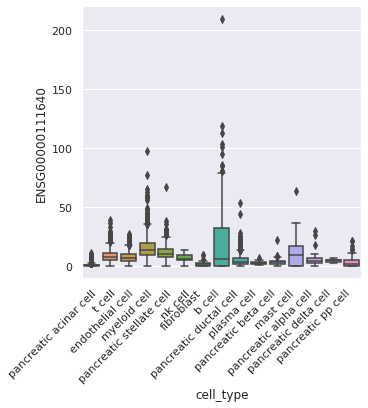

In [59]:
#boxplot of GAPDH expression across all cells grouped by cell type
plt.xticks(rotation = 45, ha = 'right', rotation_mode = 'anchor')
sns.boxplot(data = pancreas_counts, x = 'cell_type', y = 'ENSG00000111640')
sns.set(rc={'figure.figsize':(10,8)})

In [51]:
pancreas_median_counts = pd.read_pickle('pancreas_median_counts.pkl', compression = 'gzip')
pancreas_median_counts['ENSG00000111640']

cell_type
b cell                       5.350012
endothelial cell             6.884168
fibroblast                   1.182767
mast cell                    9.038163
myeloid cell                13.193433
nk cell                      6.090976
pancreatic acinar cell       0.479214
pancreatic alpha cell        4.158237
pancreatic beta cell         2.842936
pancreatic delta cell        4.811918
pancreatic ductal cell       3.555940
pancreatic pp cell           1.197720
pancreatic stellate cell    10.093762
plasma cell                  1.978243
t cell                       7.375886
Name: ENSG00000111640, dtype: float64

Some cells don't express GAPDH as highly as others reflected in their median expression values and this is particularly odd when genes that are not supposed to be highly expressed in certain cells have their expression amplified and yet those cell types have a low expression of GAPDH.

**Histogram**

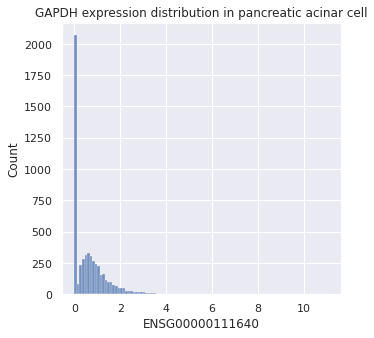

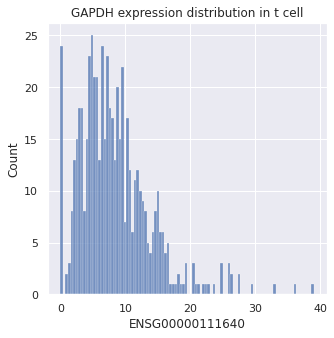

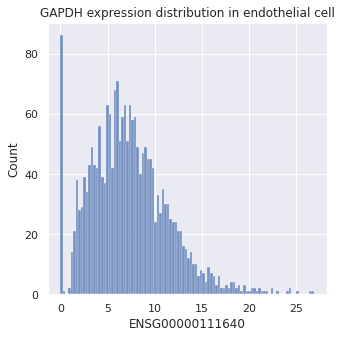

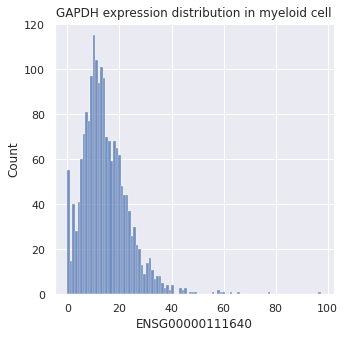

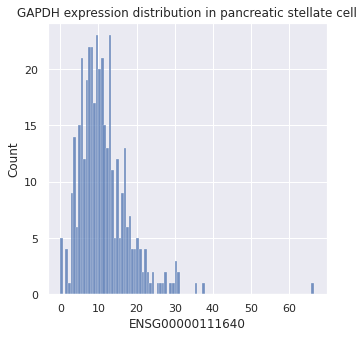

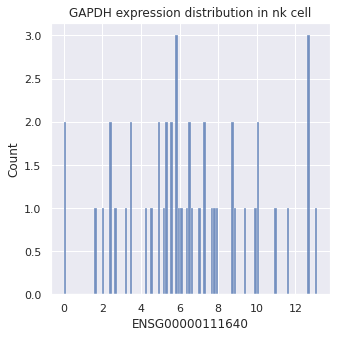

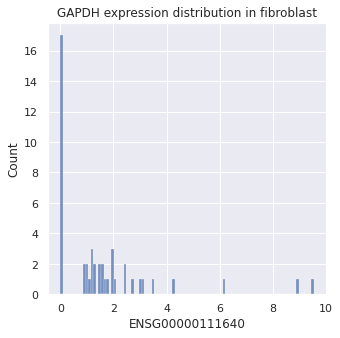

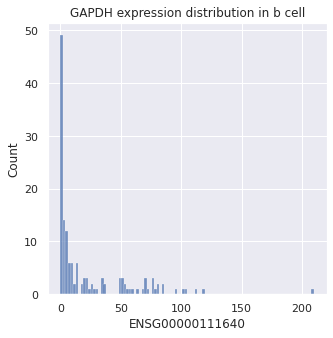

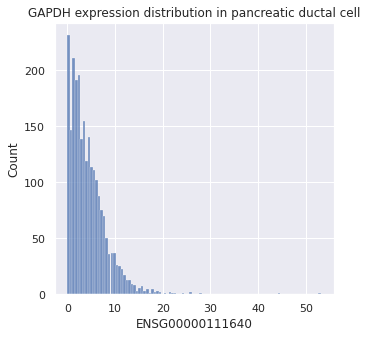

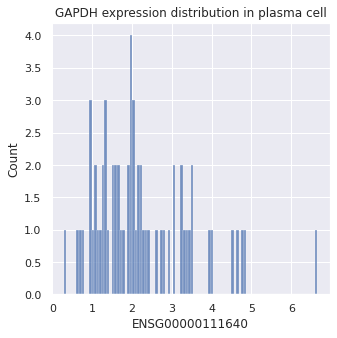

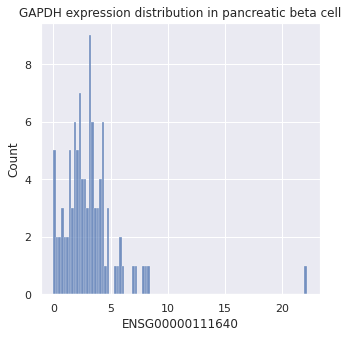

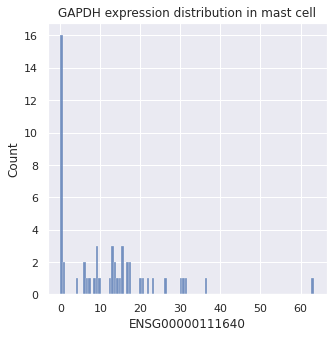

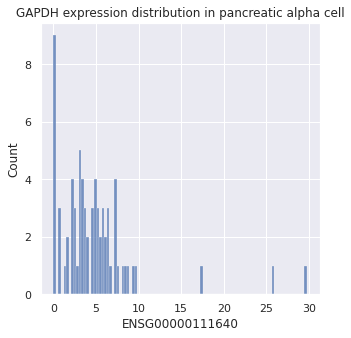

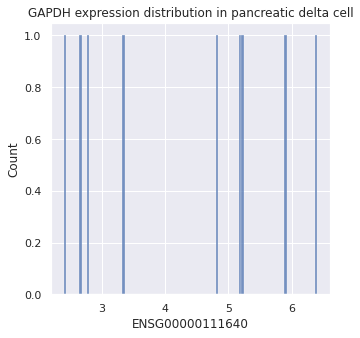

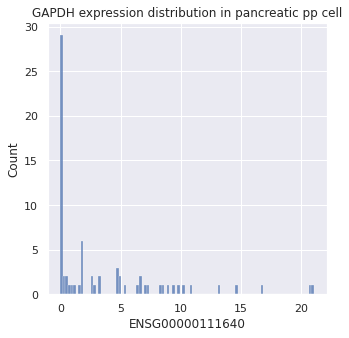

In [60]:
sns.set(rc={'figure.figsize':(5,5)})

for i in pancreas_counts.cell_type.unique():
    ax = sns.histplot(data = pancreas_counts[pancreas_counts.cell_type == i], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression distribution in {i}')
    plt.show()

In [67]:
#find cells with a zero expression of housekeeping gene GAPDH
GAPDH_zero = pancreas_counts[pancreas_counts['ENSG00000111640'] == 0]

#create dataframe for insulin expression count of cells with GADPH count of zero
df = pd.DataFrame(GAPDH_zero[['cell_type','ENSG00000254647']])

#filter df for cells with non-zero insulin expression but zero GAPDH expression
df[df.ENSG00000254647 != 0]

cell_type  ENSG00000254647
27                 fibroblast     22025.464844
35     pancreatic acinar cell      6275.698242
39     pancreatic acinar cell       889.364319
42     pancreatic acinar cell      9052.602539
58                 fibroblast      6953.983398
...                       ...              ...
13008      pancreatic pp cell     22025.464844
13019   pancreatic alpha cell     22025.464844
13030    pancreatic beta cell     22025.464844
13042      pancreatic pp cell     22025.464844
13050    pancreatic beta cell     22025.464844

[307 rows x 2 columns]

In [72]:
df[df.ENSG00000254647 != 0].min()

cell_type            b cell
ENSG00000254647    2.957891
dtype: object

In [71]:
df[df.ENSG00000254647 != 0].cell_type.unique().tolist()

['fibroblast',
 'pancreatic acinar cell',
 't cell',
 'endothelial cell',
 'pancreatic ductal cell',
 'myeloid cell',
 'pancreatic stellate cell',
 'pancreatic beta cell',
 'pancreatic alpha cell',
 'b cell',
 'pancreatic pp cell']

The cells that had a zero expression of GAPDH but a non-zero expression of insulin do appear to have higher expression values for insulin however is this a result of scaling which makes the insulin expression appear much larger compared to the GAPDH expression?????????????? These cells have different cell types and do not belong to just one.

# 5. Zero expression cells and cell types (are they the same cell types with zero expression across different indiviudal cells) check over multiple genes

In [121]:
import random
random_genes = random.choices(lung_counts.columns[1:], k = 25)

In [125]:
random_lung_df = lung_counts[random_genes]
random_lung_df.insert(0, 'cell_type', lung_counts.cell_type)
random_lung_df

cell_type  ENSG00000212829  ENSG00000249238  \
0                       type ii pneumocyte              0.0              0.0   
1                       type ii pneumocyte              0.0              0.0   
2                       type ii pneumocyte              0.0              0.0   
3                       type ii pneumocyte              0.0              0.0   
4                       type ii pneumocyte              0.0              0.0   
...                                    ...              ...              ...   
35677                           macrophage              0.0              0.0   
35678                          plasma cell              0.0              0.0   
35679  lung microvascular endothelial cell              0.0              0.0   
35680                           neutrophil              0.0              0.0   
35681                   type ii pneumocyte              0.0              0.0   

       ENSG00000165821  ENSG00000090863  ENSG00000071282  ENSG00000206579  \
0             0.000000         1.642094              0.0              0.0   
1             0.000000         0.756270              0.0              0.0   
2             0.000000         0.000000              0.0              0.0   
3            73.153236         0.000000              0.0              0.0   
4            45.637405         0.769476              0.0              0.0   
...                ...              ...              ...              ...   
35677         0.000000         0.000000              0.0              0.0   
35678         0.000000         0.032625              0.0              0.0   
35679         0.000000         0.000000              0.0              0.0   
35680         0.000000         0.000000              0.0              0.0   
35681         0.199610         1.442203              0.0              0.0   

       ENSG00000223568  ENSG00000231156  ENSG00000271063  ...  \
0                  0.0              0.0              0.0  ...   
1                  0.0              0.0              0.0  ...   
2                  0.0              0.0              0.0  ...   
3                  0.0              0.0              0.0  ...   
4                  0.0              0.0              0.0  ...   
...                ...              ...              ...  ...   
35677              0.0              0.0              0.0  ...   
35678              0.0              0.0              0.0  ...   
35679              0.0              0.0              0.0  ...   
35680              0.0              0.0              0.0  ...   
35681              0.0              0.0              0.0  ...   

       ENSG00000217809  ENSG00000204140  ENSG00000233527  ENSG00000233354  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
35677              0.0              0.0              0.0              0.0   
35678              0.0              0.0              0.0              0.0   
35679              0.0              0.0              0.0              0.0   
35680              0.0              0.0              0.0              0.0   
35681              0.0              0.0              0.0              0.0   

       ENSG00000006210  ENSG00000252132  ENSG00000154473  ENSG00000279887  \
0                  0.0              0.0         1.011633              0.0   
1                  0.0              0.0         0.754701              0.0   
2                  0.0              0.0         0.000000              0.0   
3                  0.0              0.0         0.000000              0.0   
4                  0.0              0.0         2.894969

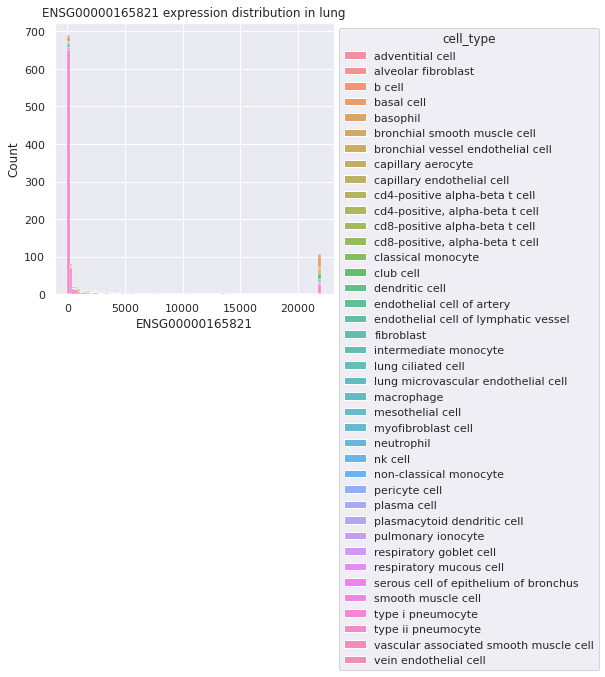

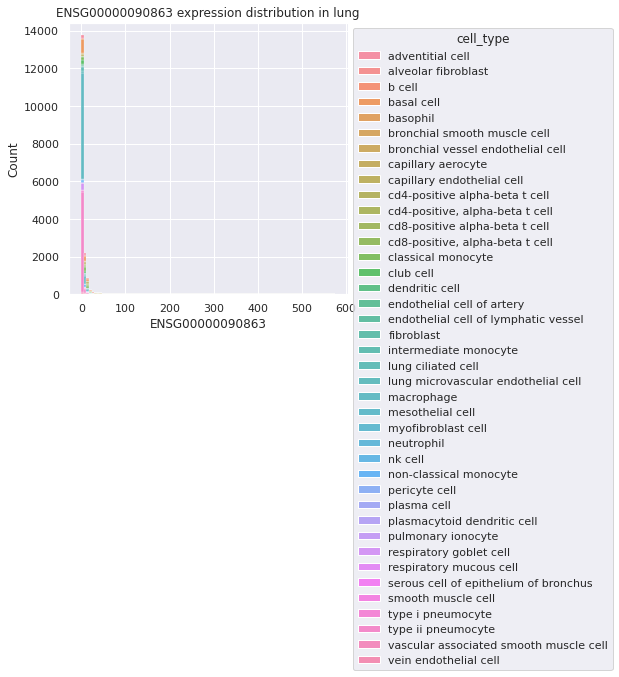

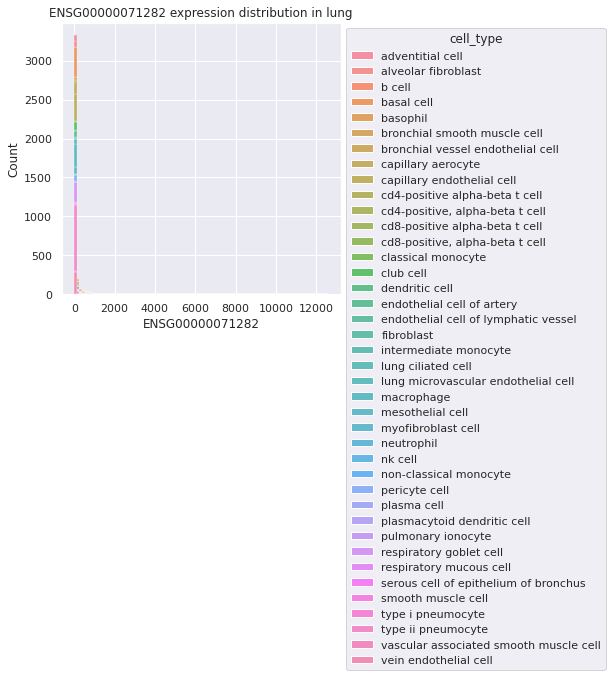

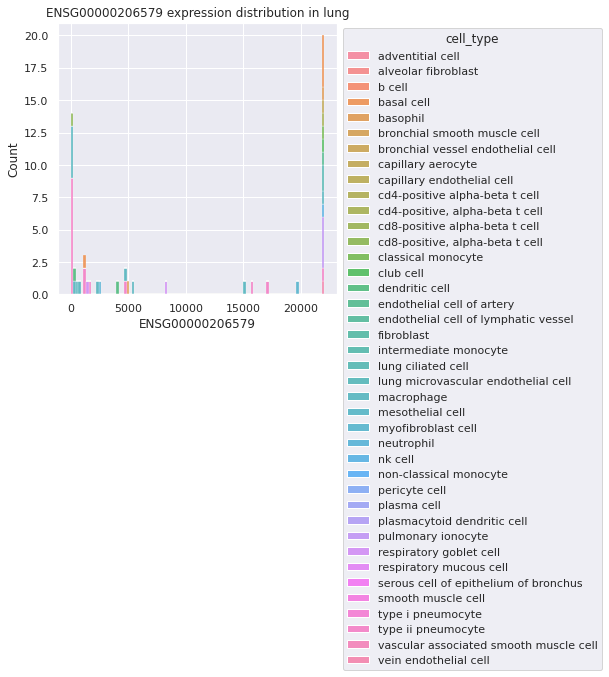

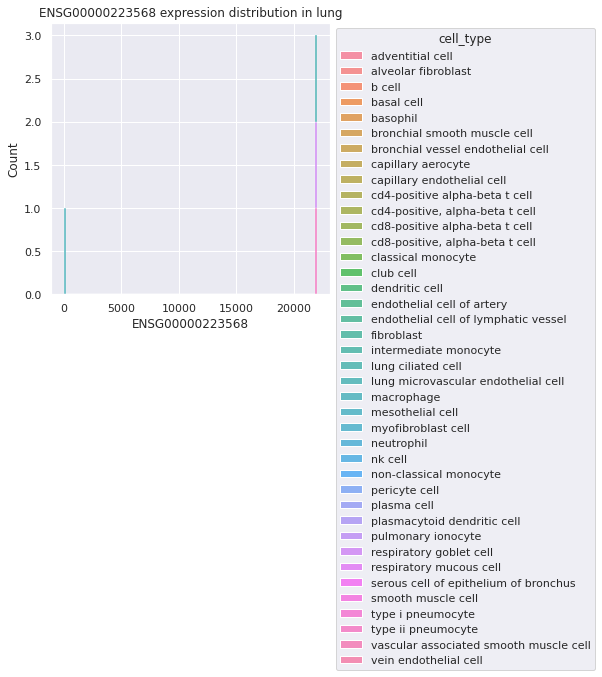

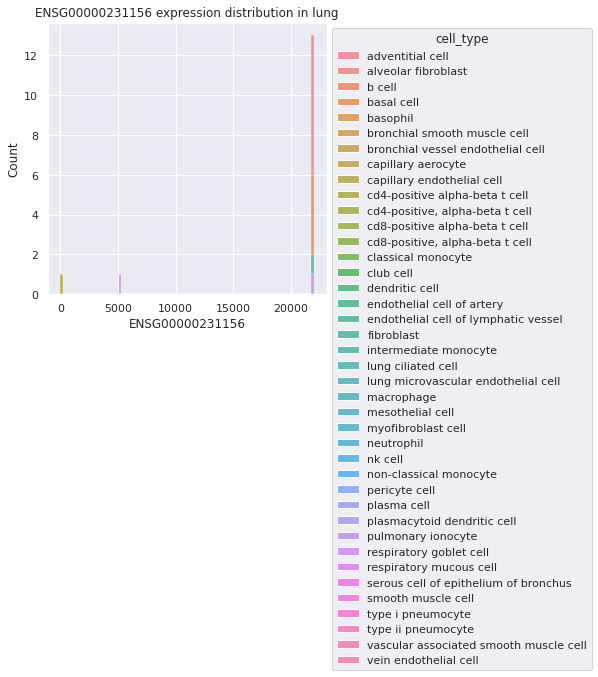

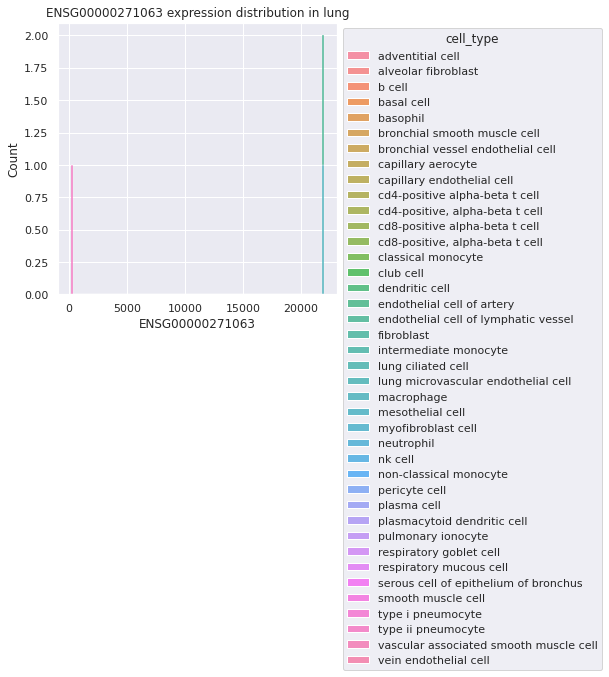

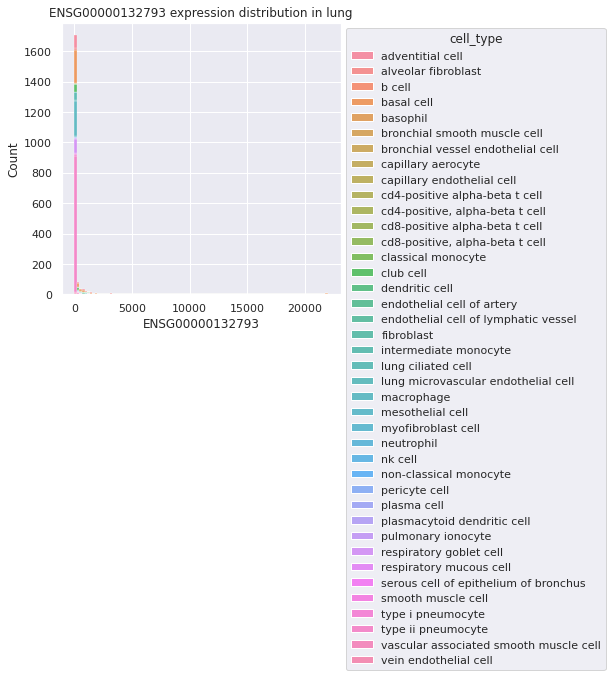

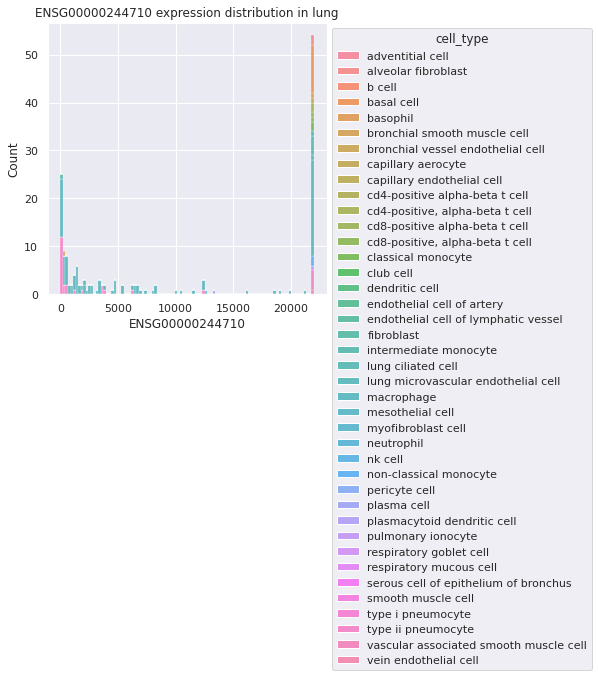

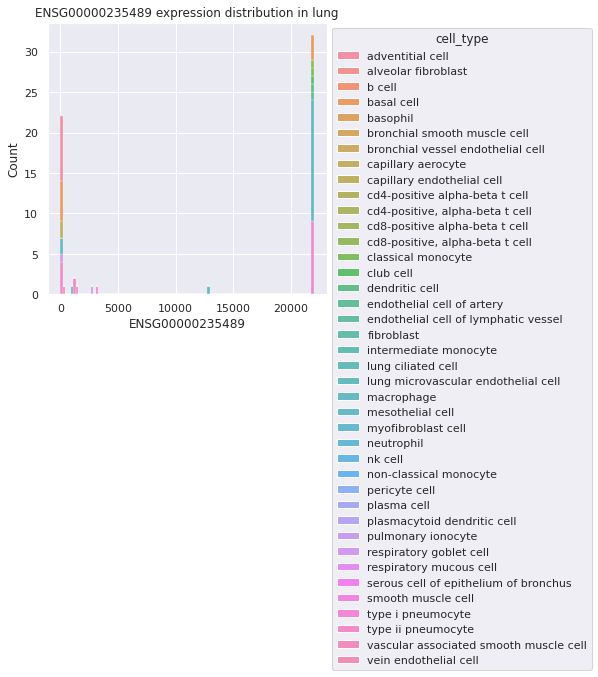

In [131]:
for i in random_lung_df.columns[3:13]:
    
    ax = sns.histplot(data = random_lung_df[random_lung_df[i] > 0], x = i, bins = 100, hue = 'cell_type', multiple = 'stack')
    sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.title(f'{i} expression distribution in lung')
    plt.show()

# 6. GAPDH expression in a cell type across different tissues
## 6.1 Macrophage

In [98]:
macrophage = all_cells_adata[all_cells_adata.obs.cell_ontology_class == 'macrophage']
macrophage_counts = pd.DataFrame.sparse.from_spmatrix(macrophage.X)
macrophage_counts = np.expm1(macrophage_counts)
macrophage_counts = macrophage_counts.sparse.to_dense()
macrophage_counts = macrophage_counts.set_axis(macrophage.var.index.values, axis = 1)
macrophage_counts.insert(0, 'tissue', macrophage.obs['tissue_ontology_term_id'].values)

In [99]:
macrophage_counts

tissue  ENSG00000223972  ENSG00000227232  ENSG00000278267  \
0      UBERON:0002107              0.0         0.000000         0.000000   
1      UBERON:0002107              0.0         0.000000         0.000000   
2      UBERON:0002107              0.0         0.000000         0.000000   
3      UBERON:0002107              0.0         0.000000         0.000000   
4      UBERON:0002107              0.0         0.000000         0.000000   
...               ...              ...              ...              ...   
35199  UBERON:0000947              0.0         0.000000         0.000000   
35200  UBERON:0000947              0.0         0.000000         0.000000   
35201  UBERON:0000947              0.0         0.000000         0.000000   
35202  UBERON:0000947              0.0         7.713166     22025.464844   
35203  UBERON:0000947              0.0         0.000000         0.000000   

       ENSG00000243485  ENSG00000284332  ENSG00000237613  ENSG00000268020  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
35199              0.0              0.0              0.0              0.0   
35200              0.0              0.0              0.0              0.0   
35201              0.0              0.0              0.0              0.0   
35202              0.0              0.0              0.0              0.0   
35203              0.0              0.0              0.0              0.0   

       ENSG00000240361  ENSG00000186092  ...  ENSG00000198886  \
0                  0.0              0.0  ...        90.290840   
1                  0.0              0.0  ...        76.020004   
2                  0.0              0.0  ...        83.139656   
3                  0.0              0.0  ...        89.980217   
4                  0.0              0.0  ...        79.205688   
...                ...              ...  ...              ...   
35199              0.0              0.0  ...         1.166046   
35200              0.0              0.0  ...         5.290343   
35201              0.0              0.0  ...         4.300599   
35202              0.0              0.0  ...         5.824342   
35203              0.0              0.0  ...         9.628598   

       ENSG00000210176  ENSG00000210184  ENSG00000210191  ENSG00000198786  \
0                  0.0              0.0              0.0        20.458338   
1                  0.0              0.0              0.0        18.596909   
2                  0.0              0.0              0.0        28.170612   
3                  0.0              0.0              0.0        31.218832   
4                  0.0              0.0              0.0        33.242493   
...                ...              ...              ...              ...   
35199              0.0              0.0              0.0        13.215845   
35200              0.0              0.0              0.0         0.260030   
35201              0.0              0.0              0.0         8.841644   
35202              0.0              0.0              0.0         4.840485   
35203              0.0              0.0              0.0        11.037820   

       ENSG00000198695  ENSG00000210194  ENSG00000198727  ENSG00000210195  \
0             4.670524              0.0       103.710594              0.0   
1             0.000000              0.0        95.801949              0.0   
2             3.661305              0.0        88.349495              0.0   
3             0.000000              0.0       103.334099              0.0   
4             1.483858              0.0        93.733696              0.0   
...      

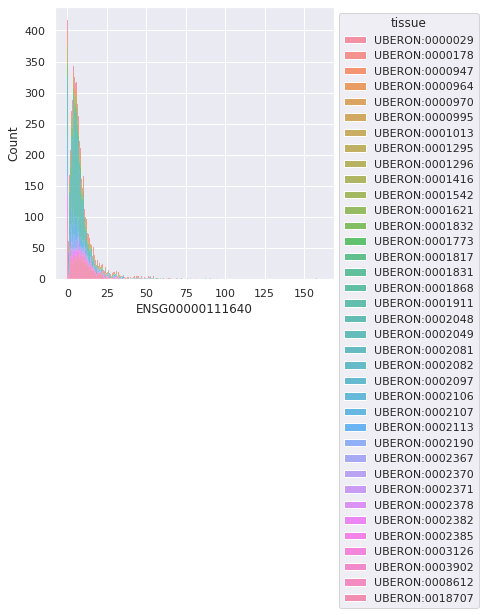

In [107]:
ax = sns.histplot(data = macrophage_counts, x = macrophage_counts['ENSG00000111640'].sample(n = 10000), hue = 'tissue', 
                  multiple = 'stack', bins = 500)

#move figure legend outside of the plot
sns.move_legend(obj = ax, loc = 'upper left', bbox_to_anchor = (1, 1))

All the tissues appear to have a normal distribution for this cell type with the GAPDH expression so it might be worth using the mode/median without the zero counts.

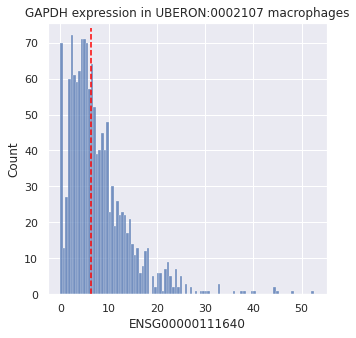

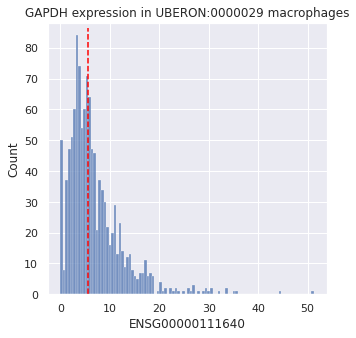

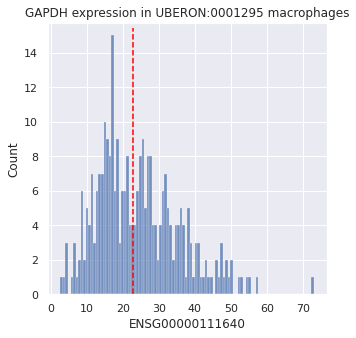

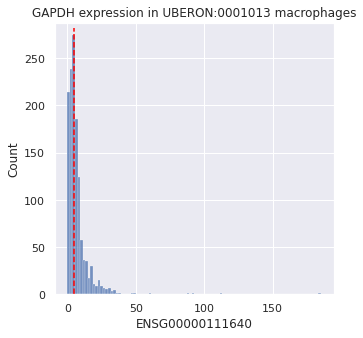

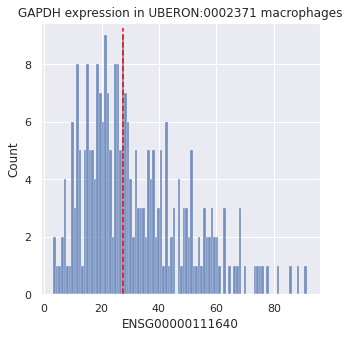

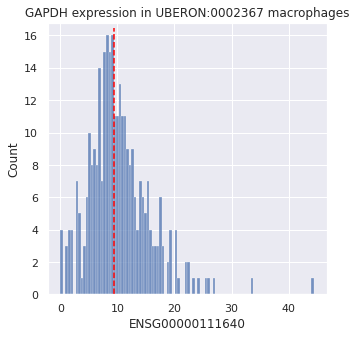

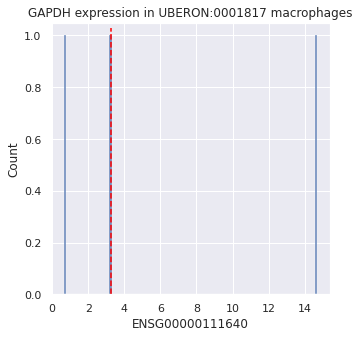

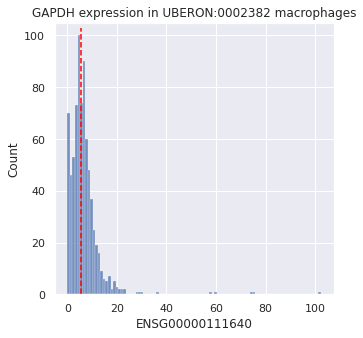

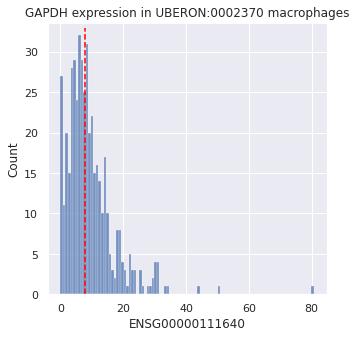

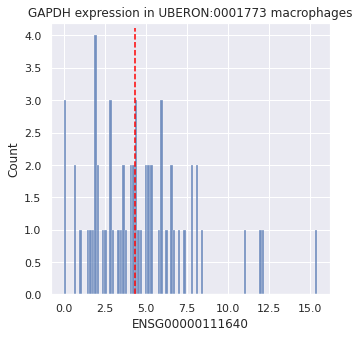

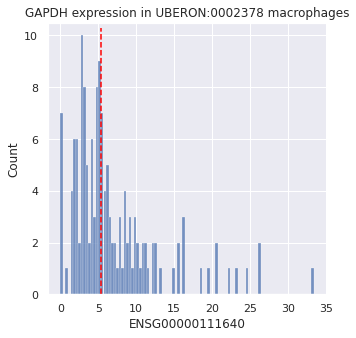

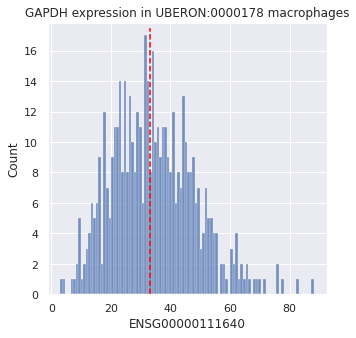

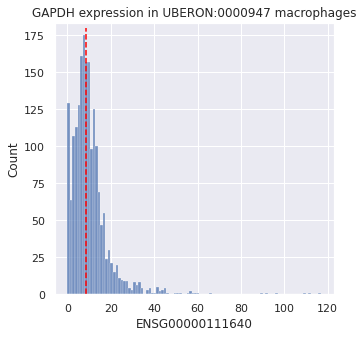

In [115]:
for i in range(0, macrophage_counts.tissue.nunique(), 3):
    
    #tissue
    tissue = macrophage_counts.tissue.unique()[i]
    
    ax = sns.histplot(data = macrophage_counts[macrophage_counts.tissue == tissue], x = 'ENSG00000111640', bins = 100)
    plt.title(f'GAPDH expression in {tissue} macrophages')
    
    ax.axvline(x = macrophage_counts[macrophage_counts.tissue == tissue]['ENSG00000111640'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')
    
    plt.show()

This shows the median expression of GAPDH for macrophages across the different tissues is a pretty good metric for most tissues and this is especially true when the number of cells is greater in these tissues as expected and it performs more poorly when the cell count is much lower. It also shows that the same cell type in different tissues can have different expression values and expression distributions for housekeeping genes.

# 7. Is there any exact duplication of cells? (following from 2.3.1)
## 7.1 Load total pancreas cells

In [5]:
total_pancreas = pd.read_pickle('total_pancreas_counts.pkl', compression = 'gzip')
total_pancreas

cell_type  ENSG00000223972  ENSG00000227232  \
0      pancreatic acinar cell              0.0         0.000000   
1                      t cell              0.0         0.000000   
2            endothelial cell              0.0         0.000000   
3      pancreatic acinar cell              0.0         0.000000   
4            endothelial cell              0.0         0.000000   
...                       ...              ...              ...   
13492  pancreatic ductal cell              0.0         0.000000   
13493  pancreatic acinar cell              0.0     22025.464844   
13494  pancreatic acinar cell              0.0         0.000000   
13495  pancreatic ductal cell              0.0         0.000000   
13496  pancreatic acinar cell              0.0         0.000000   

       ENSG00000278267  ENSG00000243485  ENSG00000284332  ENSG00000237613  \
0                  0.0              0.0              0.0              0.0   
1                  0.0              0.0              0.0              0.0   
2                  0.0              0.0              0.0              0.0   
3                  0.0              0.0              0.0              0.0   
4                  0.0              0.0              0.0              0.0   
...                ...              ...              ...              ...   
13492              0.0              0.0              0.0              0.0   
13493              0.0              0.0              0.0              0.0   
13494              0.0              0.0              0.0              0.0   
13495              0.0              0.0              0.0              0.0   
13496              0.0              0.0              0.0              0.0   

       ENSG00000268020  ENSG00000240361  ENSG00000186092  ...  \
0                  0.0              0.0              0.0  ...   
1                  0.0              0.0              0.0  ...   
2                  0.0              0.0              0.0  ...   
3                  0.0              0.0              0.0  ...   
4                  0.0              0.0              0.0  ...   
...                ...              ...              ...  ...   
13492              0.0              0.0              0.0  ...   
13493              0.0              0.0              0.0  ...   
13494              0.0              0.0              0.0  ...   
13495              0.0              0.0              0.0  ...   
13496              0.0              0.0              0.0  ...   

       ENSG00000198886  ENSG00000210176  ENSG00000210184  ENSG00000210191  \
0            34.758480              0.0              0.0              0.0   
1            48.408390              0.0              0.0              0.0   
2            24.694277              0.0              0.0              0.0   
3           122.997513              0.0              0.0              0.0   
4            24.756660              0.0              0.0              0.0   
...                ...              ...              ...              ...   
13492       207.695068              0.0              0.0              0.0   
13493         0.245305              0.0              0.0              0.0   
13494         2.323625              0.0              0.0              0.0   
13495        63.215328              0.0              0.0              0.0   
13496         0.555759              0.0              0.0              0.0   

       ENSG00000198786  ENSG00000198695  ENSG00000210194  ENSG00000198727  \
0             4.966144         3.906905         0.000000        48.869343   
1            20.399097         0.000000         0.000000        77.893944   
2             7.775723         4.148284         0.000000        59.189732   
3            22.998369        65.008820         0.000000       244.989914   
4             5.023250         3.653118         0.000000        43.362007   
...                ...              ...              ...              ...   
13492        44.736046       244.861618      

## 7.2 Count total number of each pancreatic cell type

In [6]:
total_pancreas.groupby('cell_type').cell_type.count()

cell_type
b cell                       144
endothelial cell            2100
fibroblast                    47
mast cell                     53
myeloid cell                1862
nk cell                       47
pancreatic acinar cell      5534
pancreatic alpha cell         71
pancreatic beta cell          99
pancreatic delta cell          9
pancreatic ductal cell      2431
pancreatic pp cell            71
pancreatic stellate cell     393
plasma cell                   63
t cell                       573
Name: cell_type, dtype: int64

## 7.3 Count number of each cell type across endocrine and exocrine pancreas

In [9]:
#filtering out exocrine and endocrine pancreas data
exo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000017']
endo_pancreas_adata = all_cells_adata[all_cells_adata.obs['tissue_ontology_term_id'] == 'UBERON:0000016']

#processing exocrine and endocrine pancreas count data
exo_pancreas = pd.DataFrame.sparse.from_spmatrix(exo_pancreas_adata.X)
exo_pancreas = np.expm1(exo_pancreas)
exo_pancreas = exo_pancreas.sparse.to_dense()
exo_pancreas = exo_pancreas.set_axis(exo_pancreas_adata.var.index.values, axis = 1)
exo_pancreas.insert(0, 'cell_type', exo_pancreas_adata.obs['cell_ontology_class'].values)


endo_pancreas = pd.DataFrame.sparse.from_spmatrix(endo_pancreas_adata.X)
endo_pancreas = np.expm1(endo_pancreas)
endo_pancreas = endo_pancreas.sparse.to_dense()
endo_pancreas = endo_pancreas.set_axis(endo_pancreas_adata.var.index.values, axis = 1)
endo_pancreas.insert(0, 'cell_type', endo_pancreas_adata.obs['cell_ontology_class'].values)

/home/jupyter/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [19]:
warnings.simplefilter(action='ignore', category=FutureWarning)

cell_type_counts = pd.DataFrame(exo_pancreas.groupby('cell_type').cell_type.count())
cell_type_counts = cell_type_counts.rename(columns = {'cell_type': 'exo_count'})
cell_type_counts['endo_count'] = endo_pancreas.groupby('cell_type').cell_type.count()

cell_type_counts

exo_count  endo_count
cell_type                                      
b cell                           27       117.0
endothelial cell               1927       173.0
fibroblast                       47         NaN
mast cell                         2        51.0
myeloid cell                   1805        57.0
nk cell                          47         NaN
pancreatic acinar cell         5092       442.0
pancreatic alpha cell            46        25.0
pancreatic beta cell             88        11.0
pancreatic delta cell             9         NaN
pancreatic ductal cell         1892       539.0
pancreatic pp cell                1        70.0
pancreatic stellate cell        386         7.0
plasma cell                      63         NaN
t cell                          545        28.0

It doesn't appear from first glance that any of the cells within the cell types have been exactly duplicated across the endocrine and exocrine pancreas.

## 7.4 Look into whether any two cells have exactly the same expression vector across all genes

In [48]:
gene_columns = total_pancreas.drop(columns = 'cell_type').columns.to_list()
duplicate_rows = total_pancreas.drop(columns = 'cell_type').duplicated(subset = gene_columns, keep = False)
duplicate_rows.unique()

array([False])

From this code, there appears to be NO duplicated cells in this data meaning that the duplicated expression values are due to perhaps an upper limit in the expression.

# 8. Developing algorithm for more accurate average metric (initially in liver)

## 8.1 Read in data

In [9]:
liver_adata = sc.read_h5ad('tabula_sapiens_liver.h5ad')
liver = pd.DataFrame.sparse.from_spmatrix(liver_adata.X)
liver = np.expm1(liver)
liver = liver.sparse.to_dense()
liver = liver.set_axis(liver_adata.var.index.values, axis = 1)
liver.insert(0, 'cell_type', liver_adata.obs['cell_ontology_class'].values)

## 8.2 Filter data for one cell type that has a limited number of cells and remove genes with zero expression across all cells of the cell type

In [10]:
liver_dendritic_cell = liver[liver['cell_type'] == 'liver dendritic cell']

In [11]:
liver_dendritic_cell = liver_dendritic_cell.drop(liver_dendritic_cell.columns[(liver_dendritic_cell == 0).all()], axis = 1)

## 8.3 Plot expression distributions for genes with median line

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


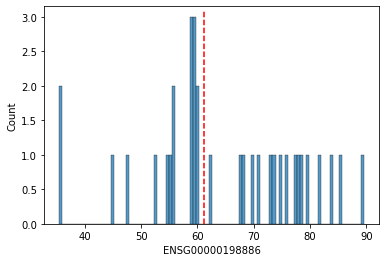

In [12]:
ax = sns.histplot(data = liver_dendritic_cell, x = 'ENSG00000198886', bins = 100)

ax.axvline(x = liver_dendritic_cell['ENSG00000198886'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')

/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jupyter/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


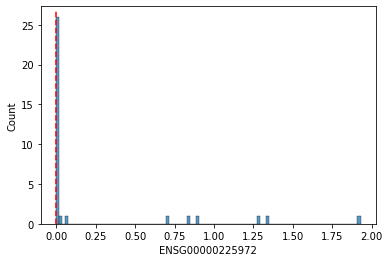

In [13]:
ax = sns.histplot(data = liver_dendritic_cell, x = 'ENSG00000225972', bins = 100)
ax.axvline(x = liver_dendritic_cell['ENSG00000225972'].median(),
              ymin = 0, ymax = 0.98, color = 'red', linestyle = 'dashed')

## 8.4 Plot KDE plot for selected gene ENSG00000198886

Density plot is a smoothed, continuous version of a histogram estimated from the data. The most common form is kernel density estimation where at every point a continuous curve (kernel) is drawn and the curves are added together to make a smooth density estimation. Kernel most often used is Gaussian.

In [73]:
ENSG00000198886 = liver_dendritic_cell['ENSG00000198886'].to_numpy()
ENSG00000198886

array([84.08877 , 73.326775, 55.434254, 75.912506, 60.019104, 89.53477 ,
       73.05935 , 52.44103 , 59.533394, 55.739616, 77.55819 , 81.710785,
       68.382126, 78.03767 , 59.06656 , 85.33592 , 74.75249 , 59.7253  ,
       60.092297, 58.906292, 55.67934 , 69.601944, 62.33324 , 67.86767 ,
       59.69369 , 79.59635 , 47.622116, 71.15295 , 78.485306, 58.956673,
       54.53691 , 45.10832 , 35.48385 , 35.65818 ], dtype=float32)

In [78]:
def gene_kde_plot(data):
    
    #import required packages
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    
    #create histogram
    plt.hist(data, bins=100, density=True, color='blue', alpha=0.6, label='Histogram')
    
    #calculate KDE line
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 10000)
    kde_values = kde(x)
    
    #find mode of KDE
    mode_index = np.argmax(kde_values)
    mode_x = x[mode_index]
    
    #shift KDE curve to centre on mode
    kde_values_shifted = kde_values / kde_values[mode_index]
    
    #plot shifted KDE line
    plt.plot(x, kde_values_shifted, color = 'red', label = 'KDE')
    
    #add axis labels and legend
    plt.xlabel(f'Gene expression values')
    plt.ylabel('Probability density')
    plt.legend()
    plt.show()
    
    #return modal value for KDE curve
    mode_value = x[np.argmax(kde_values_shifted)]
    
    return mode_value

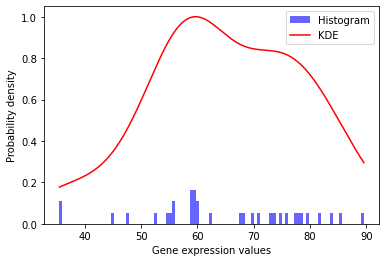

59.66324239159145

In [79]:
gene_kde_plot(ENSG00000198886)

In [80]:
np.median(ENSG00000198886)

61.21277

Compare this to the median value of 61.21 and my estimation from the KDE looks better.

## 8.5 Plot KDE curves for more genes from different liver cell types
### 8.5.1 Select random subset of 5 cell types and 3 genes

In [115]:
import random

random_cell_types = random.sample(liver.cell_type.unique().tolist(), k = 5)
random_genes = random.sample(liver.columns[1:].tolist(), k = 3)

In [116]:
random_cell_types

['nk cell', 'neutrophil', 'erythrocyte', 'endothelial cell', 'fibroblast']

In [117]:
random_genes

['ENSG00000278374', 'ENSG00000279962', 'ENSG00000021300']

### 8.5.2 Update KDE plotting function to include cases where all the expression values are the same

In [4]:
def gene_kde_plot(data):
    
    #import required packages
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    
    #create histogram
    plt.hist(data, bins=100, density=True, color='blue', alpha=0.6, label='Histogram')
    
    #check if all data values are the same
    if np.all(data == data[0]):
        
        #handle case when all values are the same
        plt.axvline(data[0], color = 'red', linestyle = 'dashed', label = 'Single Value KDE')
        
        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.show()
        
        return data[0]
        
    else:
        #calculate KDE line
        kde = gaussian_kde(data)
        x = np.linspace(min(data), max(data), 10000)
        kde_values = kde(x)

        #find mode of KDE
        mode_index = np.argmax(kde_values)
        mode_x = x[mode_index]

        #shift KDE curve to centre on mode
        kde_values_shifted = kde_values / kde_values[mode_index]

        #plot shifted KDE line
        plt.plot(x, kde_values_shifted, color = 'red', label = 'KDE')
        
        #return modal value for KDE curve
        mode_value = x[np.argmax(kde_values_shifted)]

        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.legend()
        plt.show()

        return mode_value

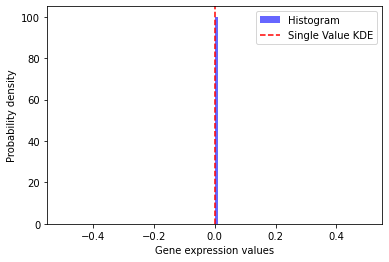

0.0

In [127]:
nk = liver[liver['cell_type'] == 'nk cell']
ENSG00000278374 = nk['ENSG00000278374'].to_numpy()
gene_kde_plot(ENSG00000278374)

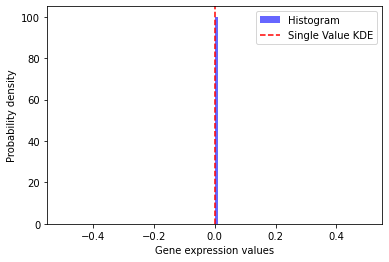

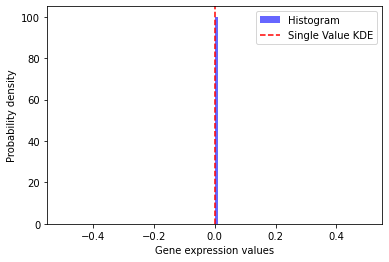

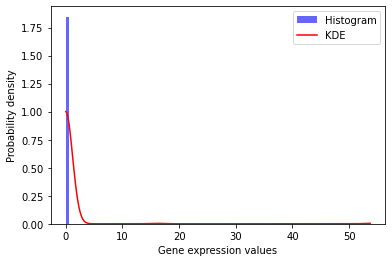

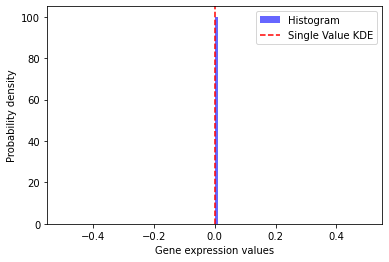

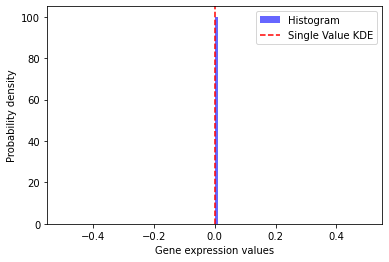

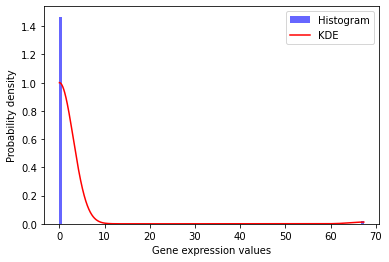

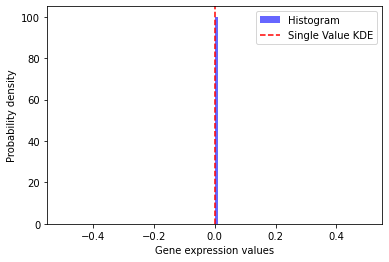

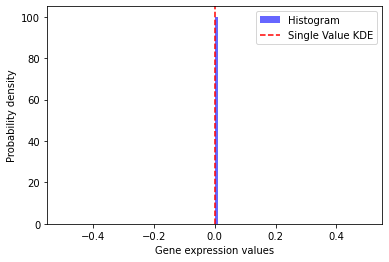

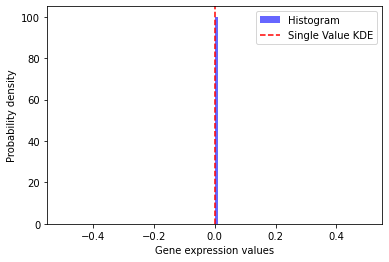

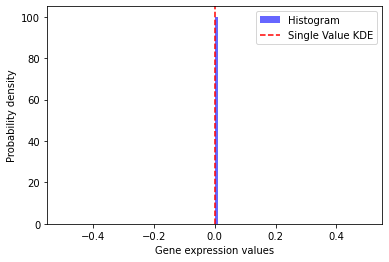

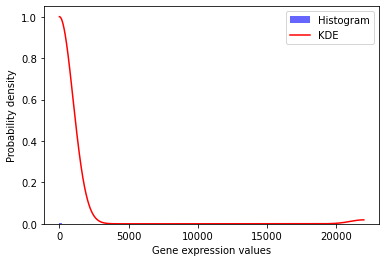

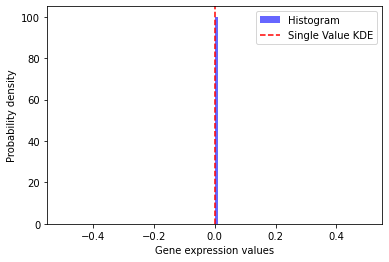

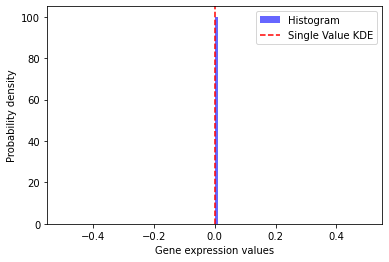

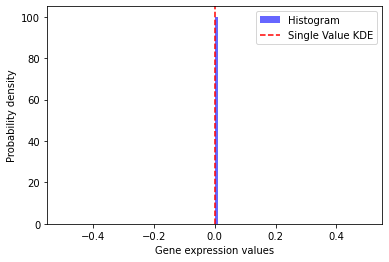

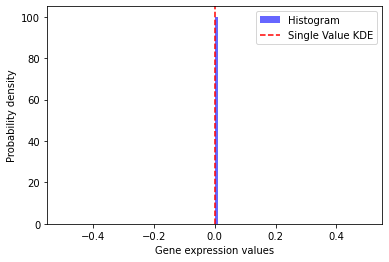

In [128]:
for cell_type in random_cell_types:
    
    cell_type_df = liver[liver['cell_type'] == cell_type]
    
    for gene in random_genes:
        
        gene_data = cell_type_df[gene].to_numpy()
        
        gene_kde_plot(gene_data)

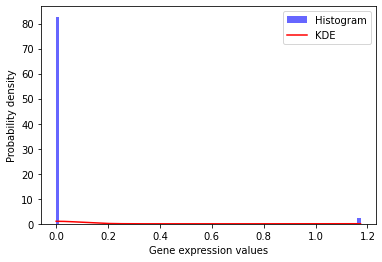

0.0

In [129]:
ENSG00000279457 = liver_dendritic_cell['ENSG00000279457'].to_numpy()
gene_kde_plot(ENSG00000279457)

# 9. Plotting KDE for randomly sampled genes and cell types across all tissues
## 9.1 Load in Tabula all cells data and function

In [2]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [3]:
def gene_kde_plot(uberonid, cell_type, ensemblid):
    
    #import required packages
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.stats import gaussian_kde
    
    #subset gene data to be used
    tissue_df = tabula[tabula['tissue'] == uberonid]
    cell_type_df = tissue_df[tissue_df['cell_type'] == cell_type]
    data = cell_type_df[ensemblid].to_numpy()
    
    
    #create histogram
    plt.hist(data, bins=100, density=True, color='blue', alpha=0.6, label='Histogram')
    
    #check if all data values are the same
    if np.all(data == data[0]):
        
        #handle case when all values are the same
        plt.axvline(data[0], color = 'red', linestyle = 'dashed', label = 'Single Value KDE')
        
        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.title(f'{uberonid}, {cell_type}, {ensemblid}')
        plt.legend()
        plt.show()
        
        return print(data[0])
        
    else:
        #calculate KDE line
        kde = gaussian_kde(data)
        x = np.linspace(min(data), max(data), 10000)
        kde_values = kde(x)

        #find mode of KDE
        mode_index = np.argmax(kde_values)
        mode_x = x[mode_index]

        #shift KDE curve to centre on mode
        kde_values_shifted = kde_values / kde_values[mode_index]

        #plot shifted KDE line
        plt.plot(x, kde_values_shifted, color = 'red', label = 'KDE')
        
        #return modal value for KDE curve
        mode_value = x[np.argmax(kde_values_shifted)]

        #add axis labels and legend
        plt.xlabel(f'Gene expression values')
        plt.ylabel('Probability density')
        plt.title(f'{uberonid}, {cell_type}, {ensemblid}')
        plt.legend()
        plt.show()

        return print(mode_value)

**Demonstration that the function works**

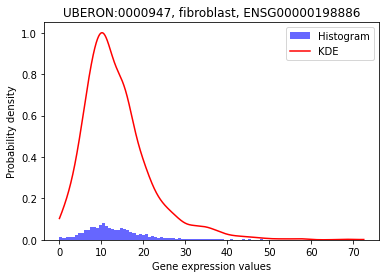

10.144010959476075


In [90]:
gene_kde_plot('UBERON:0000947', 'fibroblast', 'ENSG00000198886')

## 9.2 Select 10 random combinations of tissue-cell type-gene and plot KDEs

In [80]:
import random
import itertools

#unique combinations of gene, cell_type and tissue
unique_combo = tabula[['tissue', 'cell_type']].drop_duplicates()

#randomly select 10 unique combinations
random_combo = unique_combo.sample(n = 10, random_state = 24).reset_index(drop = True)

#create list for random unique combinations
random_combo_list = []

#iterate through randomly selected combinations and choose a random gene
for index, row in random_combo.iterrows():
    gene_columns = tabula[(tabula['tissue'] == row['tissue']) & (tabula['cell_type'] == row['cell_type'])].columns
    random_gene = np.random.choice(gene_columns)
    random_combo_list.append([row['tissue'], row['cell_type'], random_gene])

In [81]:
random_combo_list

[['UBERON:0001416', 'endothelial cell', 'ENSG00000251600'],
 ['UBERON:0001831', 'adventitial cell', 'ENSG00000176371'],
 ['UBERON:0000059', 'intestinal tuft cell', 'ENSG00000198125'],
 ['UBERON:0001868',
  'naive thymus-derived cd8-positive, alpha-beta t cell',
  'ENSG00000183579'],
 ['UBERON:0001811', 'corneal keratocyte', 'ENSG00000267179'],
 ['UBERON:0002367', 'hillock cell of prostate epithelium', 'ENSG00000105143'],
 ['UBERON:0002097', 'naive b cell', 'ENSG00000201708'],
 ['UBERON:0002049', 'macrophage', 'ENSG00000222594'],
 ['UBERON:0002048', 'fibroblast', 'ENSG00000271387'],
 ['UBERON:0002385', 'cd4-positive, alpha-beta t cell', 'ENSG00000145283']]

This has generated a list of unique combinations of tissue-celltype-gene which we can access by indexing the list. `random_combo[combination][tissue/cell_type/gene]` will enable access to each individual term within each item of the list. **E.g:**

In [84]:
random_combo_list[2][2]

'ENSG00000198125'

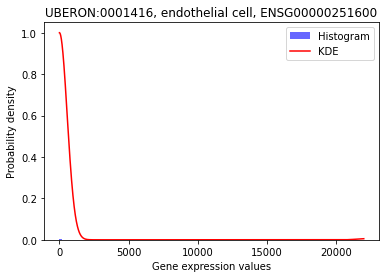

0.0


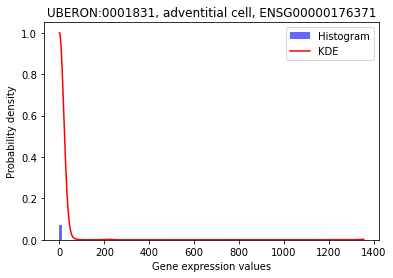

0.13550593340584058


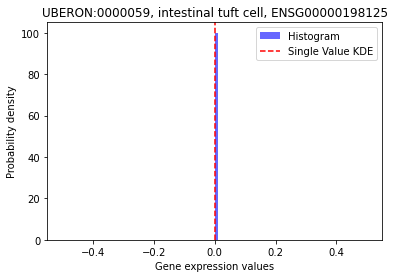

0.0


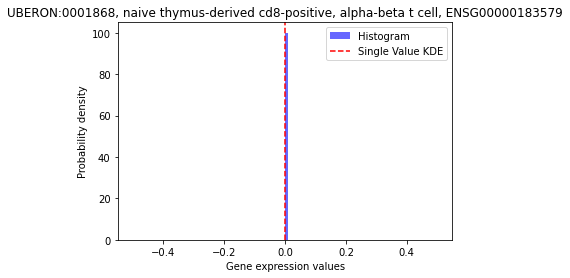

0.0


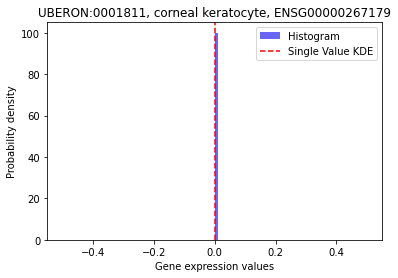

0.0


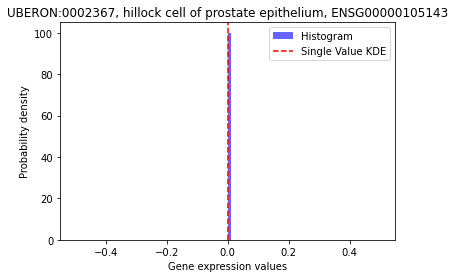

0.0


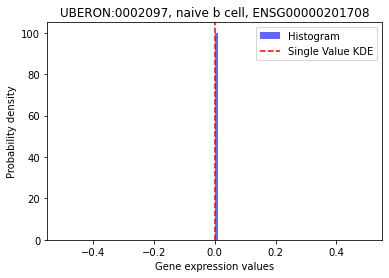

0.0


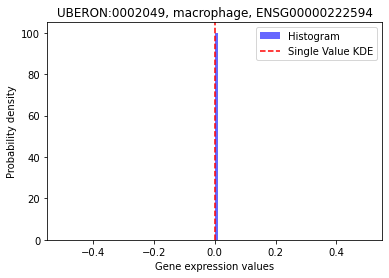

0.0


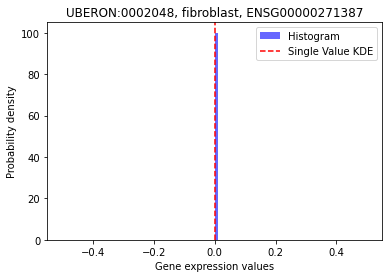

0.0


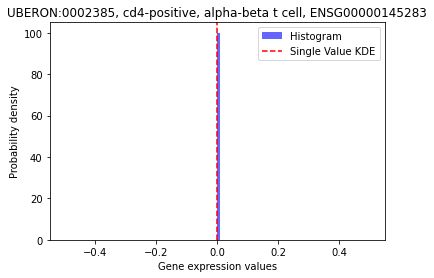

0.0


In [95]:
for combination in random_combo_list:
    
    #set tissue, cell type and gene from list index
    tissue = combination[0]
    cell_type = combination[1]
    gene = combination[2]
    
    gene_kde_plot(tissue, cell_type, gene)

# 10. Plot 100 histograms of expression across different tissues, cell-types and genes
## 10.1 Generate random tissues, cell-types and genes

In [2]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [3]:
import random

random_tissues = random.sample(tabula.tissue.unique().tolist(), k = 2)
tissue1 = tabula[tabula['tissue'] == random_tissues[0]]
tissue2 = tabula[tabula['tissue'] == random_tissues[1]]

random_cell_type1 = random.sample(tissue1.cell_type.unique().tolist(), k = 5)
random_cell_type2 = random.sample(tissue2.cell_type.unique().tolist(), k = 5)
random_genes = random.sample(tabula.columns[1:].tolist(), k = 10)
random_genes.insert(0, 'cell_type')

## 10.2 Tissue 1

In [4]:
tissue1_df = tabula[(tabula['tissue'] == random_tissues[0]) & (tabula['cell_type'].isin(
    random_cell_type1))].loc[:, random_genes].reset_index(drop = True)

In [5]:
agg_tissue1_df = tissue1_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue1_df = agg_tissue1_df.loc[random_cell_type1]

agg_tissue1_df

/tmp/ipykernel_1028/236561084.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue1_df = tissue1_df.groupby('cell_type').agg(lambda x: list(x))


ENSG00000161149  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha-beta t cell                                              [0.0]   
melanocyte                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                   ENSG00000243777  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha-beta t cell                                              [0.0]   
melanocyte                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                   ENSG00000273129  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha-beta t cell                                              [0.0]   
melanocyte                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                   ENSG00000231548  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha-beta t cell                                              [0.0]   
melanocyte                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                   ENSG00000262543  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha-beta t cell                                              [0.0]   
melanocyte                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                   ENSG00000243388  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha-beta t cell                                              [0.0]   
melanocyte                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                   ENSG00000230318  \
cell_type                                                                            
monocyte                                                           [0.0, 0.0, 0.0]   
erythroid lineage cell                                                       [0.0]   
conjunctival epithelial cell     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
cd4-positive, alpha

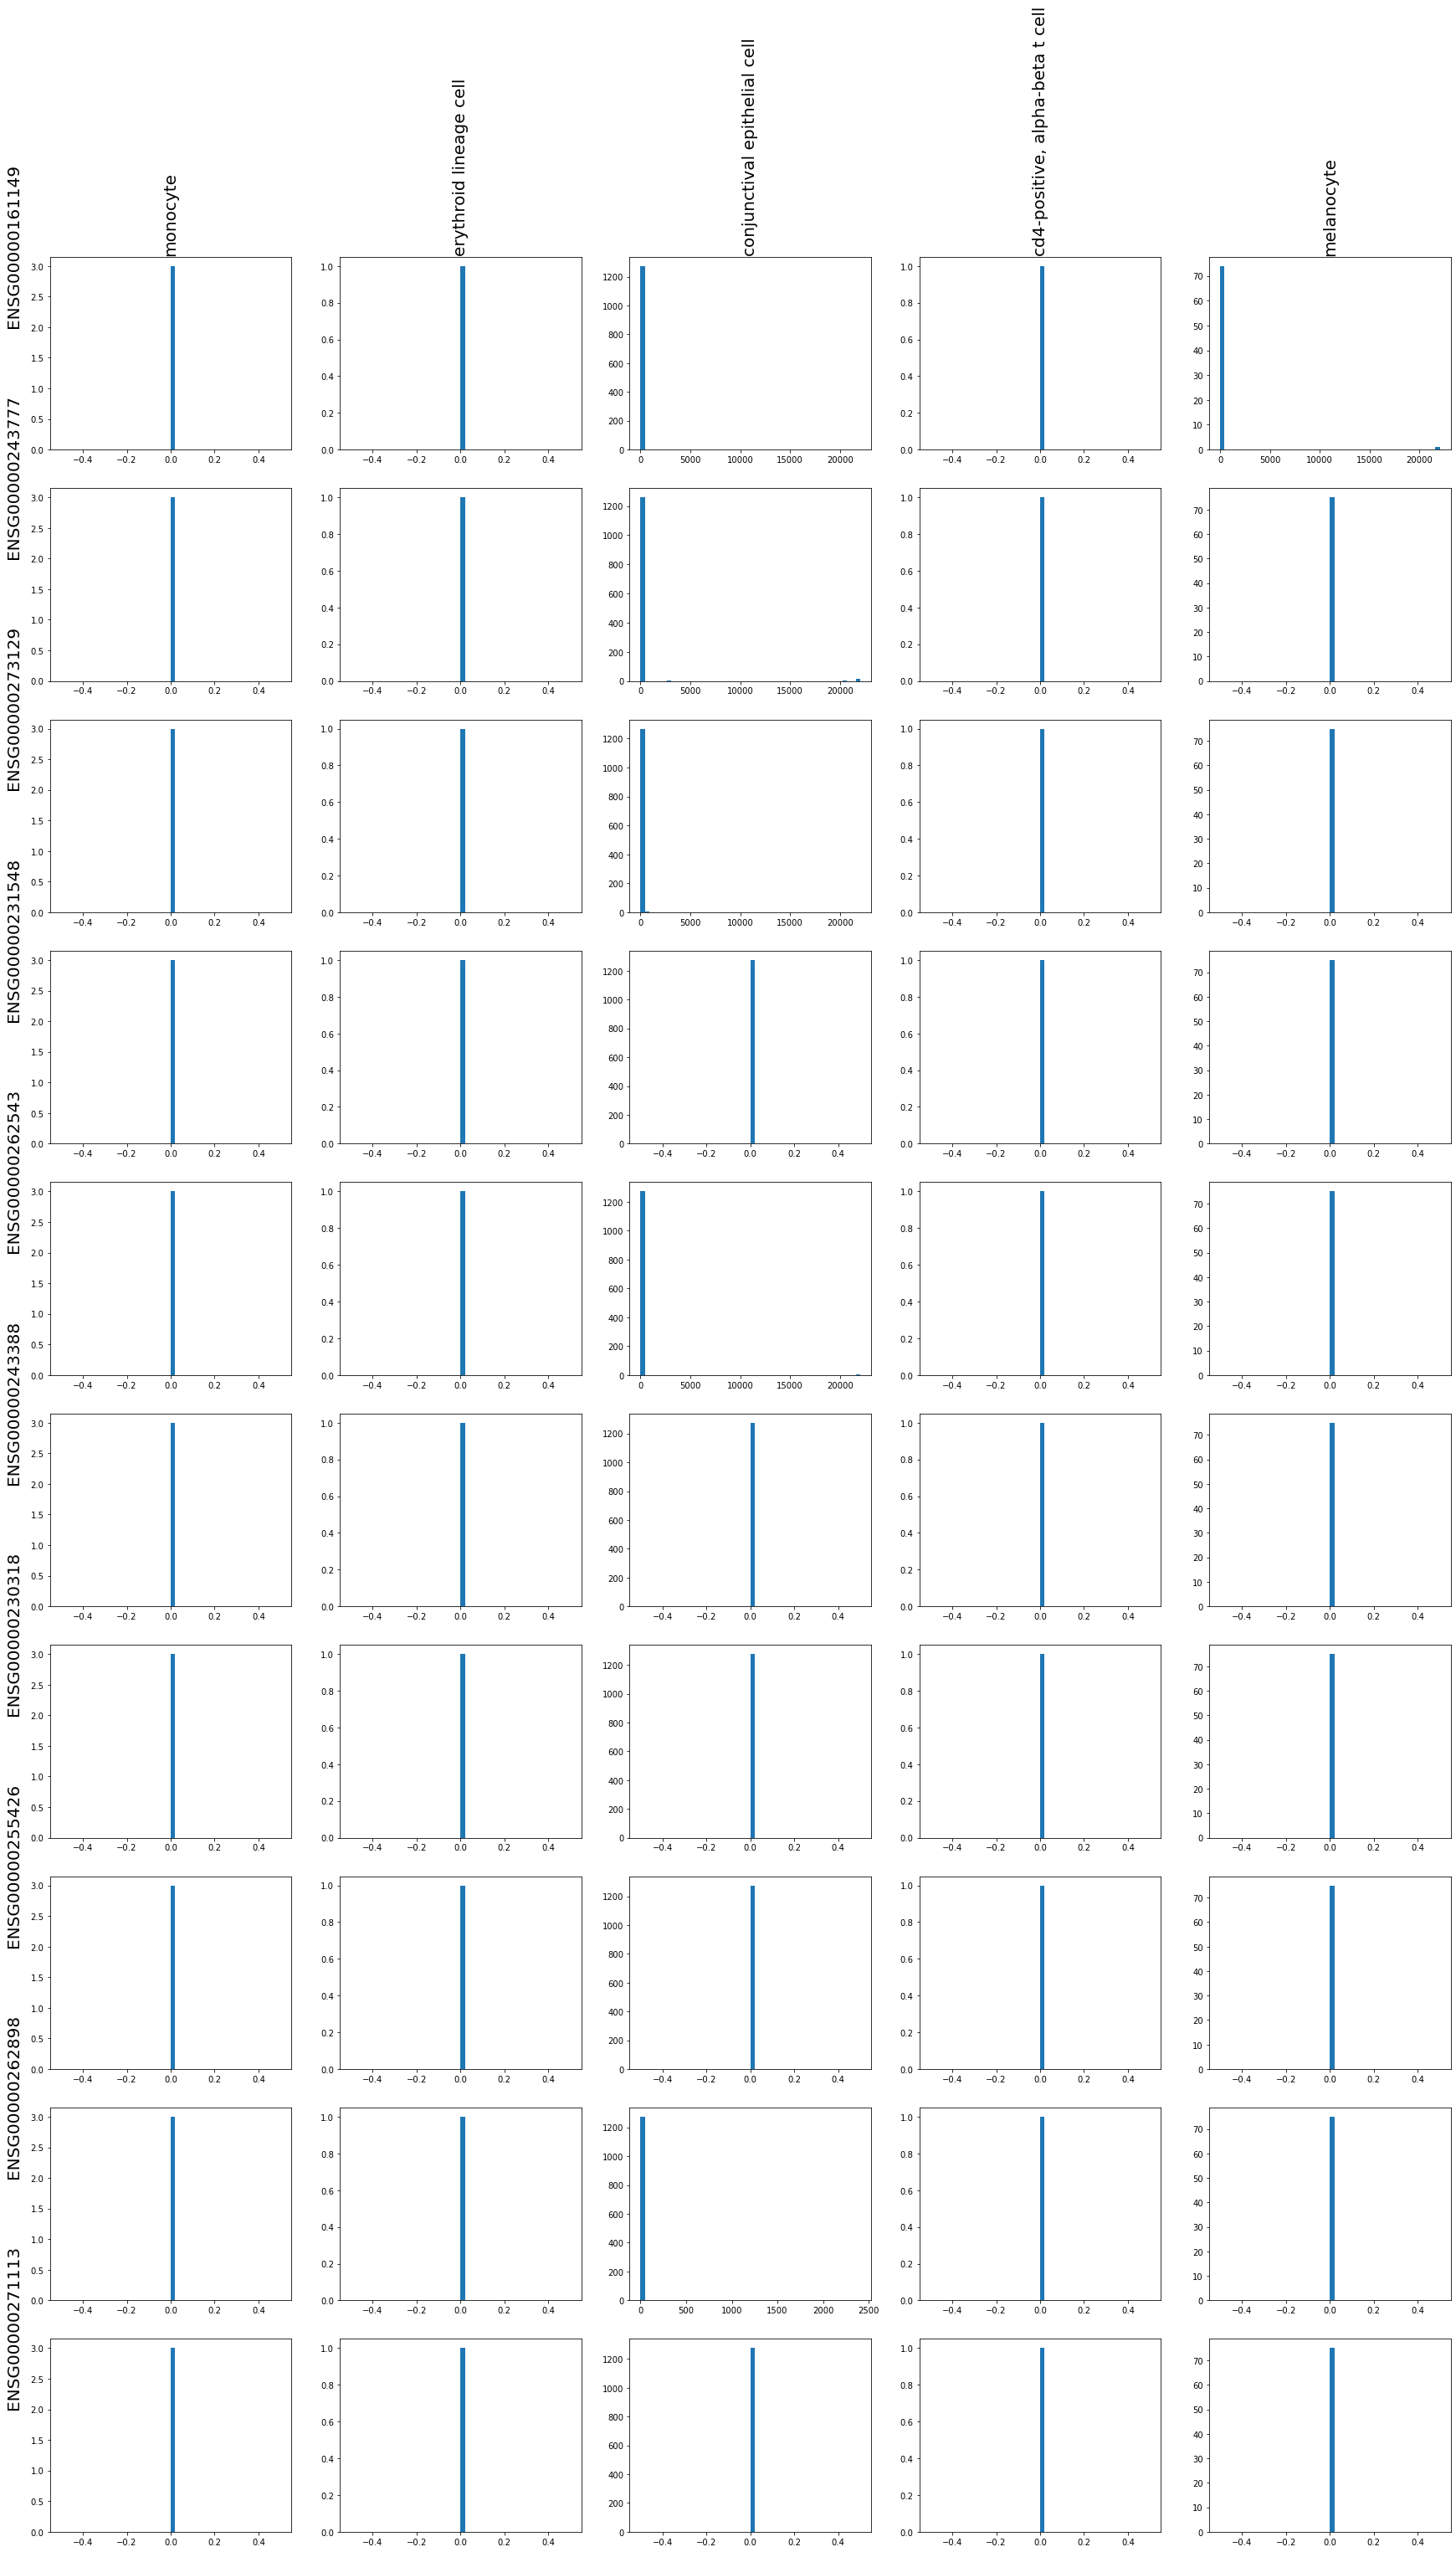

<Figure size 432x288 with 0 Axes>

In [6]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue1_df.index.to_list()
genes = agg_tissue1_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue1_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20, rotation = 'vertical')
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].text(-0.75, 2, gene, fontsize=20, rotation='vertical', va='bottom')
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually from separate tab

## 10.3 Tissue 2

In [120]:
tissue2_df = tabula[(tabula['tissue'] == random_tissues[1]) & (tabula['cell_type'].isin(
    random_cell_type2))].loc[:, random_genes].reset_index(drop = True)

agg_tissue2_df = tissue2_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue2_df = agg_tissue2_df.loc[random_cell_type2]

agg_tissue2_df

/tmp/ipykernel_1016/3129933891.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue2_df = tissue2_df.groupby('cell_type').agg(lambda x: list(x))


ENSG00000102575  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 451.7273864746094, 0.0, 0.0, 0...   
endothelial cell of artery            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pericyte cell                         [1.3658249378204346, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
mature nk t cell                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
endothelial cell of lymphatic vessel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000234172  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of artery            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pericyte cell                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
mature nk t cell                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
endothelial cell of lymphatic vessel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000230863  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of artery            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pericyte cell                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.58335423...   
mature nk t cell                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
endothelial cell of lymphatic vessel  [0.0, 0.0, 8.612548828125, 0.0, 0.0, 0.0, 0.78...   

                                                                        ENSG00000201623  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of artery            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pericyte cell                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
mature nk t cell                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
endothelial cell of lymphatic vessel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000285330  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of artery            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pericyte cell                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
mature nk t cell                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
endothelial cell of lymphatic vessel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000253875  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell of artery            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
pericyte cell                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
mature nk t cell                                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
endothelial cell of lymphatic vessel  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                                        ENSG00000262140  \
cell_type                                                                                 
macrophage                            [0.0, 0.0, 0.0, 0.0, 0.0

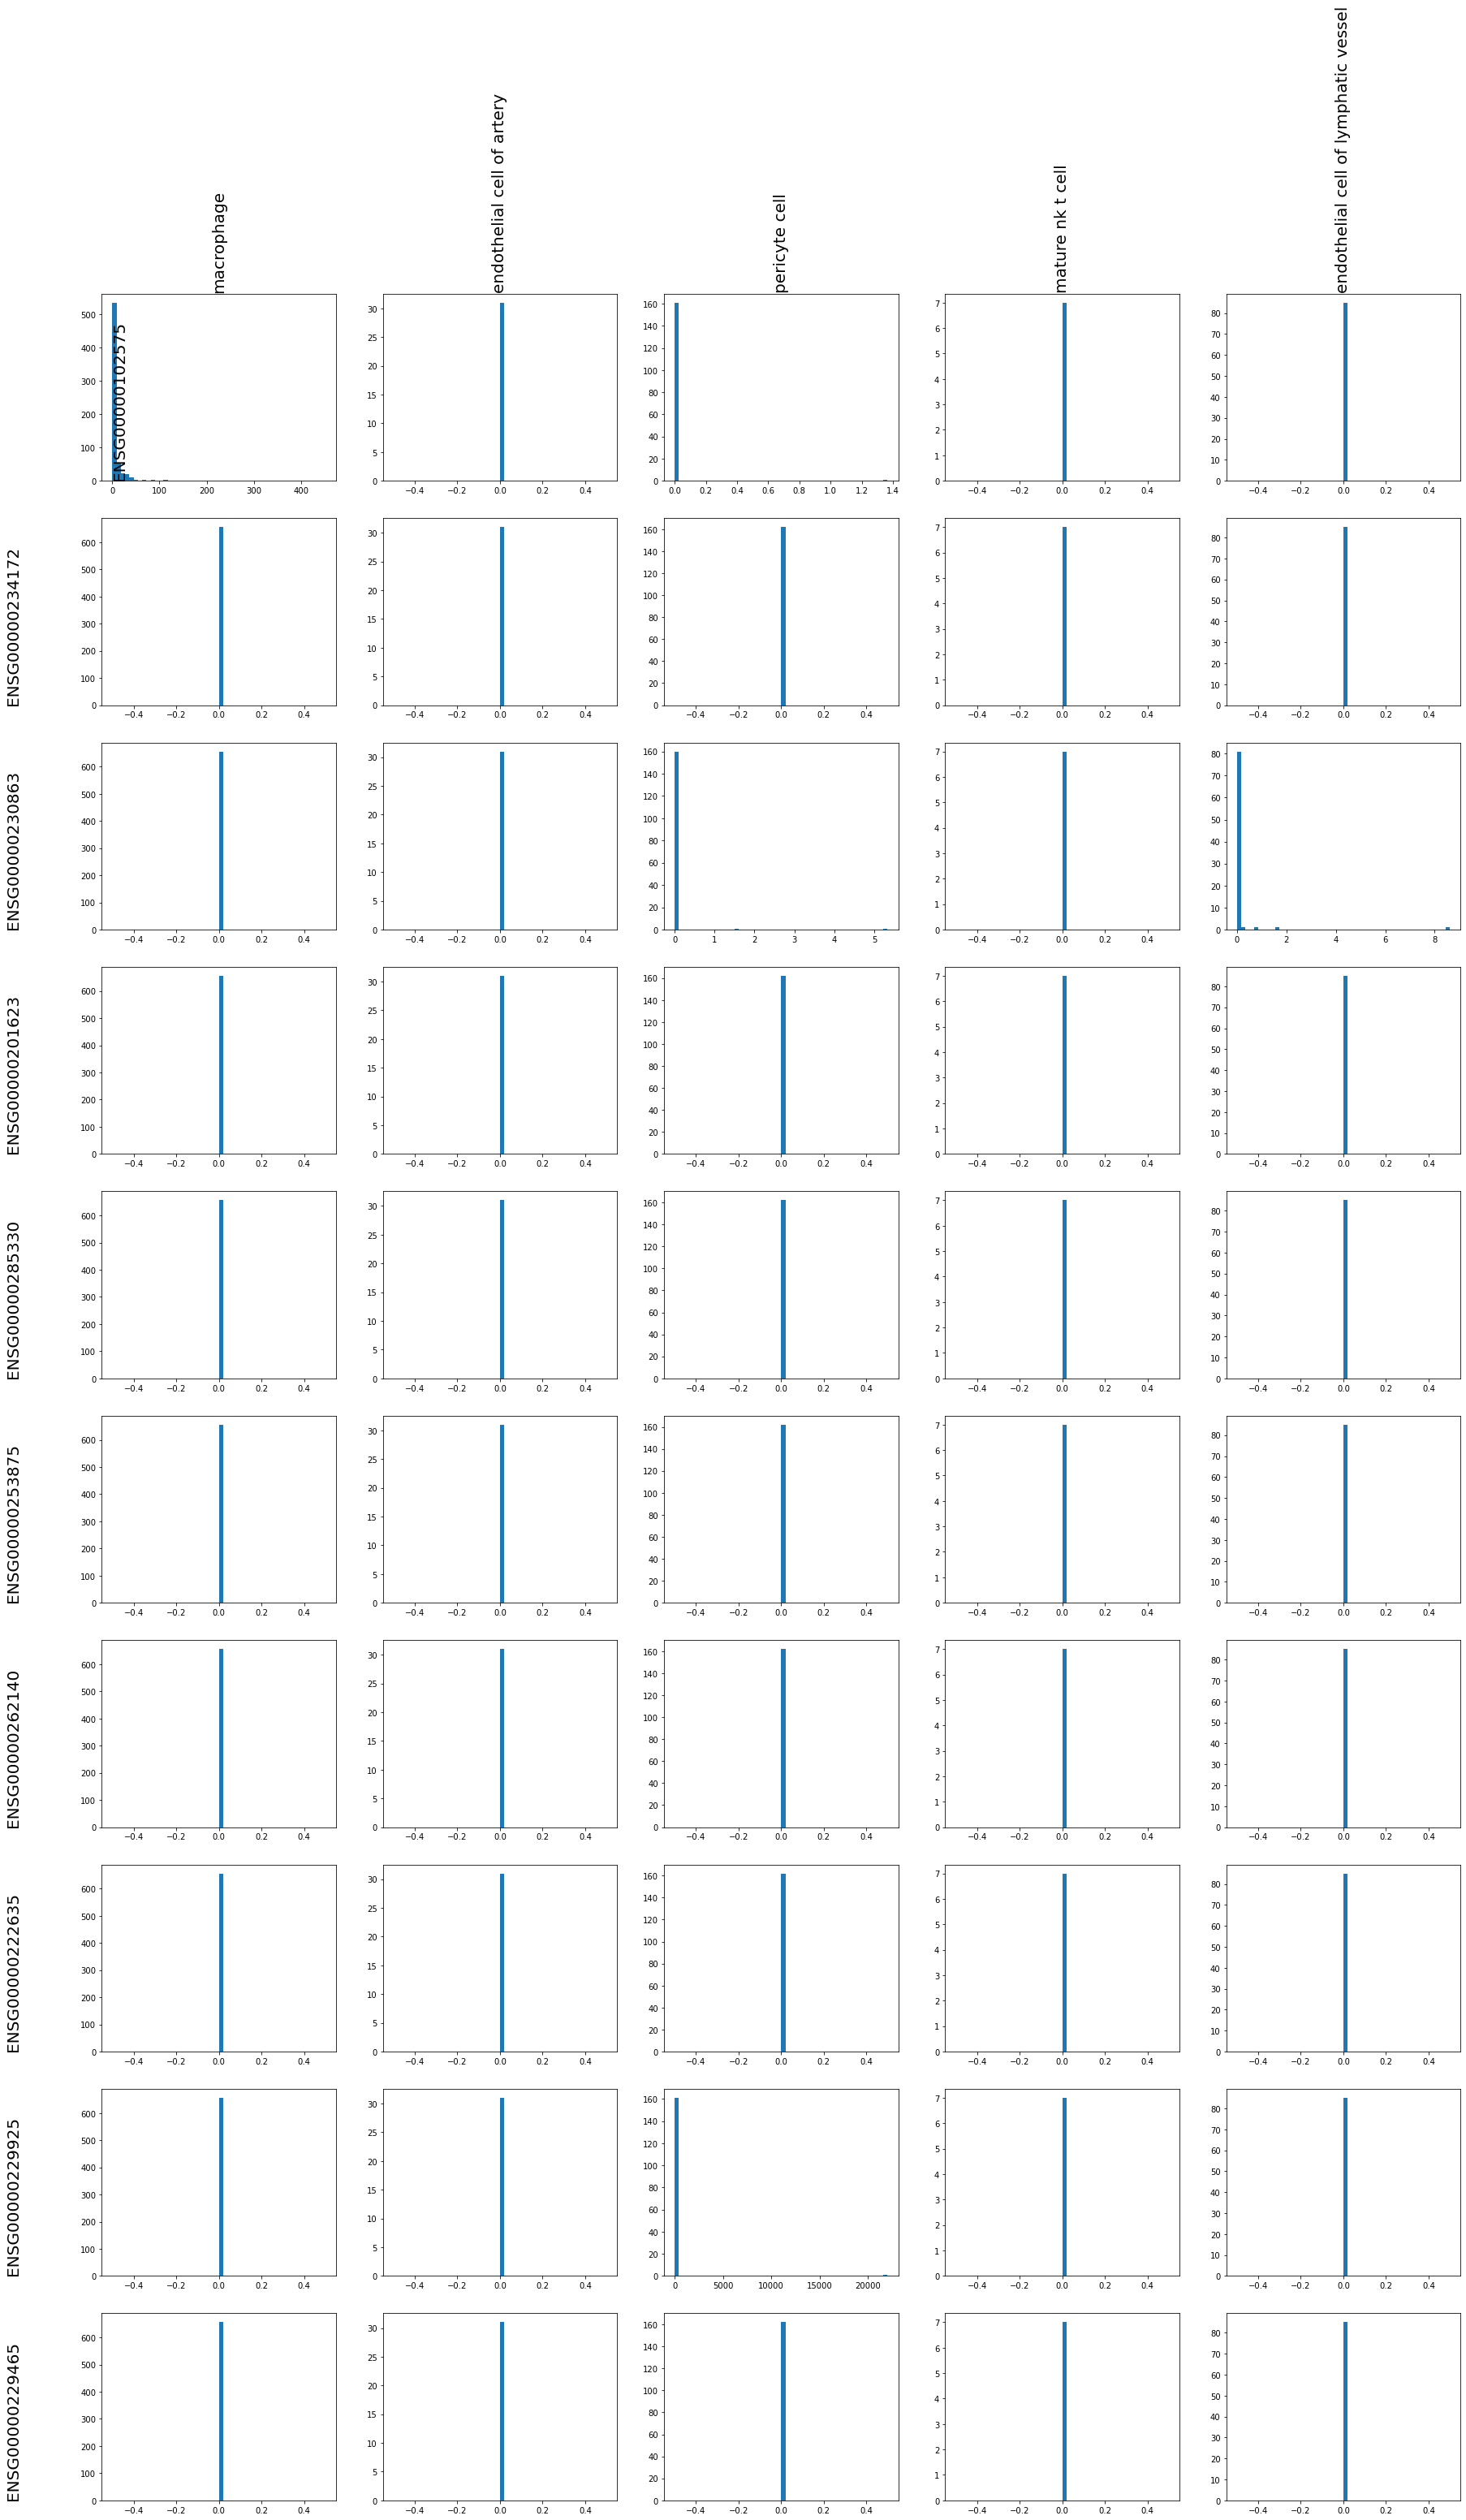

<Figure size 432x288 with 0 Axes>

In [131]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue2_df.index.to_list()
genes = agg_tissue2_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue2_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20, rotation = 'vertical')
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0]..set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually by opening in new tab and saving

## 10.4 Chose random tissues that have a bigger spread of data

In [50]:
import random

tissue = tabula[tabula['tissue'] == 'UBERON:0002107']
random_cell_type = random.sample(tissue.cell_type.unique().tolist(), k = 5)

random_genes = df.index[0:10].tolist()
random_genes.insert(0, 'cell_type')

In [51]:
tabula.loc[:, random_genes]

cell_type  ENSG00000225972  \
0                                 macrophage         0.000000   
1                                   monocyte         0.000000   
2       endothelial cell of hepatic sinusoid         0.000000   
3                                 macrophage         0.864310   
4                       liver dendritic cell         0.000000   
...                                      ...              ...   
483147                      endothelial cell         0.000000   
483148                      endothelial cell         0.000000   
483149                      endothelial cell         0.601445   
483150                      endothelial cell         0.000000   
483151                      endothelial cell         0.000000   

        ENSG00000237973  ENSG00000248527  ENSG00000175756  ENSG00000242485  \
0              0.000000         9.110065         0.000000         0.000000   
1              0.000000        12.022921         0.000000         0.000000   
2              0.000000        15.280798         0.000000         7.401144   
3              0.000000         5.952224         0.000000         0.000000   
4              0.000000         9.201199         3.602248         0.000000   
...                 ...              ...              ...              ...   
483147         0.000000         2.075939         0.000000         0.000000   
483148         0.000000         0.000000         0.000000         0.000000   
483149         0.000000         2.554697         0.457989         0.000000   
483150         0.000000         0.000000         0.000000         0.000000   
483151         0.254013         0.147913         0.000000         0.000000   

        ENSG00000078369  ENSG00000157916  ENSG00000116251  ENSG00000171735  \
0              6.522692         0.000000         4.768983         3.980816   
1              0.000000         0.000000         8.814994         0.000000   
2             10.911011         3.811964         4.669156         0.000000   
3              1.878056         0.000000         3.441710         0.000000   
4              7.885827         0.000000        18.033468         4.852810   
...                 ...              ...              ...              ...   
483147         0.000000         0.000000         2.676939         0.000000   
483148         0.000000         0.000000         0.000000         0.000000   
483149         0.429005         0.203380         0.000000         0.205205   
483150         0.000000         0.000000         0.000000         0.577591   
483151         0.000000         0.318900         0.000000         0.000000   

        ENSG00000116288  
0              2.198684  
1              0.000000  
2              0.000000  
3              1.549582  
4              5.917374  
...                 ...  
483147         0.000000  
483148         1.701459  
483149         0.000000  
483150         1.271009  
483151         0.223961  

[483152 rows x 11 columns]

In [52]:
tissue_df = tabula[(tabula['tissue'] == 'UBERON:0002107') & (tabula['cell_type'].isin(
    random_cell_type))].loc[:, random_genes].reset_index(drop = True)

agg_tissue_df = tissue_df.groupby('cell_type').agg(lambda x: list(x))
agg_tissue_df = agg_tissue_df.loc[random_cell_type]

agg_tissue_df

/tmp/ipykernel_12385/1652757010.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_tissue_df = tissue_df.groupby('cell_type').agg(lambda x: list(x))


ENSG00000225972  \
cell_type                                                                       
t cell                      [0.0, 2.4618077278137207, 0.0, 0.0, 0.0, 2.177...   
intrahepatic cholangiocyte  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
endothelial cell            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
monocyte                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3880271911621...   
nk cell                     [0.0, 1.5508159399032593, 0.0, 0.0, 0.0, 0.0, ...   

                                                              ENSG00000237973  \
cell_type                                                                       
t cell                      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.72242307...   
intrahepatic cholangiocyte  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.55568712...   
endothelial cell            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
monocyte                    [0.0, 0.0, 3.120405673980713, 4.09710502624511...   
nk cell                     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                              ENSG00000248527  \
cell_type                                                                       
t cell                      [14.299408912658691, 14.481576919555664, 13.36...   
intrahepatic cholangiocyte  [8.866147994995117, 16.073474884033203, 18.235...   
endothelial cell            [4.03476619720459, 3.1732380390167236, 0.0, 3....   
monocyte                    [12.022920608520508, 12.331391334533691, 10.27...   
nk cell                     [11.899259567260742, 17.770410537719727, 14.20...   

                                                              ENSG00000175756  \
cell_type                                                                       
t cell                      [8.114184379577637, 0.0, 0.0, 0.0, 0.0, 0.0, 0...   
intrahepatic cholangiocyte  [7.725270748138428, 7.767508506774902, 11.5538...   
endothelial cell            [6.052219867706299, 0.0, 0.0, 5.44111108779907...   
monocyte                    [0.0, 0.0, 23.77400779724121, 0.0, 0.0, 0.0, 0...   
nk cell                     [2.564769744873047, 0.0, 2.446136236190796, 0....   

                                                              ENSG00000242485  \
cell_type                                                                       
t cell                      [8.315364837646484, 8.468710899353027, 7.54257...   
intrahepatic cholangiocyte  [6.738417148590088, 7.957605838775635, 11.8715...   
endothelial cell            [0.0, 2.659224033355713, 0.0, 0.0, 8.898832321...   
monocyte                    [0.0, 14.299544334411621, 9.044212341308594, 0...   
nk cell                     [0.0, 0.0, 0.0, 7.566845893859863, 2.258532524...   

                                                              ENSG00000078369  \
cell_type                                                                       
t cell                      [0.0, 0.0, 0.0, 0.0, 0.0, 6.112723350524902, 0...   
intrahepatic cholangiocyte  [4.891072750091553, 6.810243606567383, 9.97140...   
endothelial cell            [0.0, 0.0, 0.0, 0.0, 0.0, 6.512637138366699, 3...   
monocyte                    [0.0, 11.900813102722168, 13.31353759765625, 1...   
nk cell                     [2.331453561782837, 0.0, 2.2263948917388916, 0...   

                                                              ENSG00000157916  \
cell_type                                                                       
t cell                      [11.642152786254883, 35.896697998046875, 10.45...   
intrahepatic cholangiocyte  [11.024799346923828, 0.0, 0.0, 2.3628370761871...   
endothelial cell            [8.417495727539062, 3.369992256164551, 0.0, 0....   
monocyte                    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.840193748474...   
nk cell                     [8.730464935302734, 0.0, 3.138986349105835, 0....   

                                                              ENSG00000116251  \
cell_

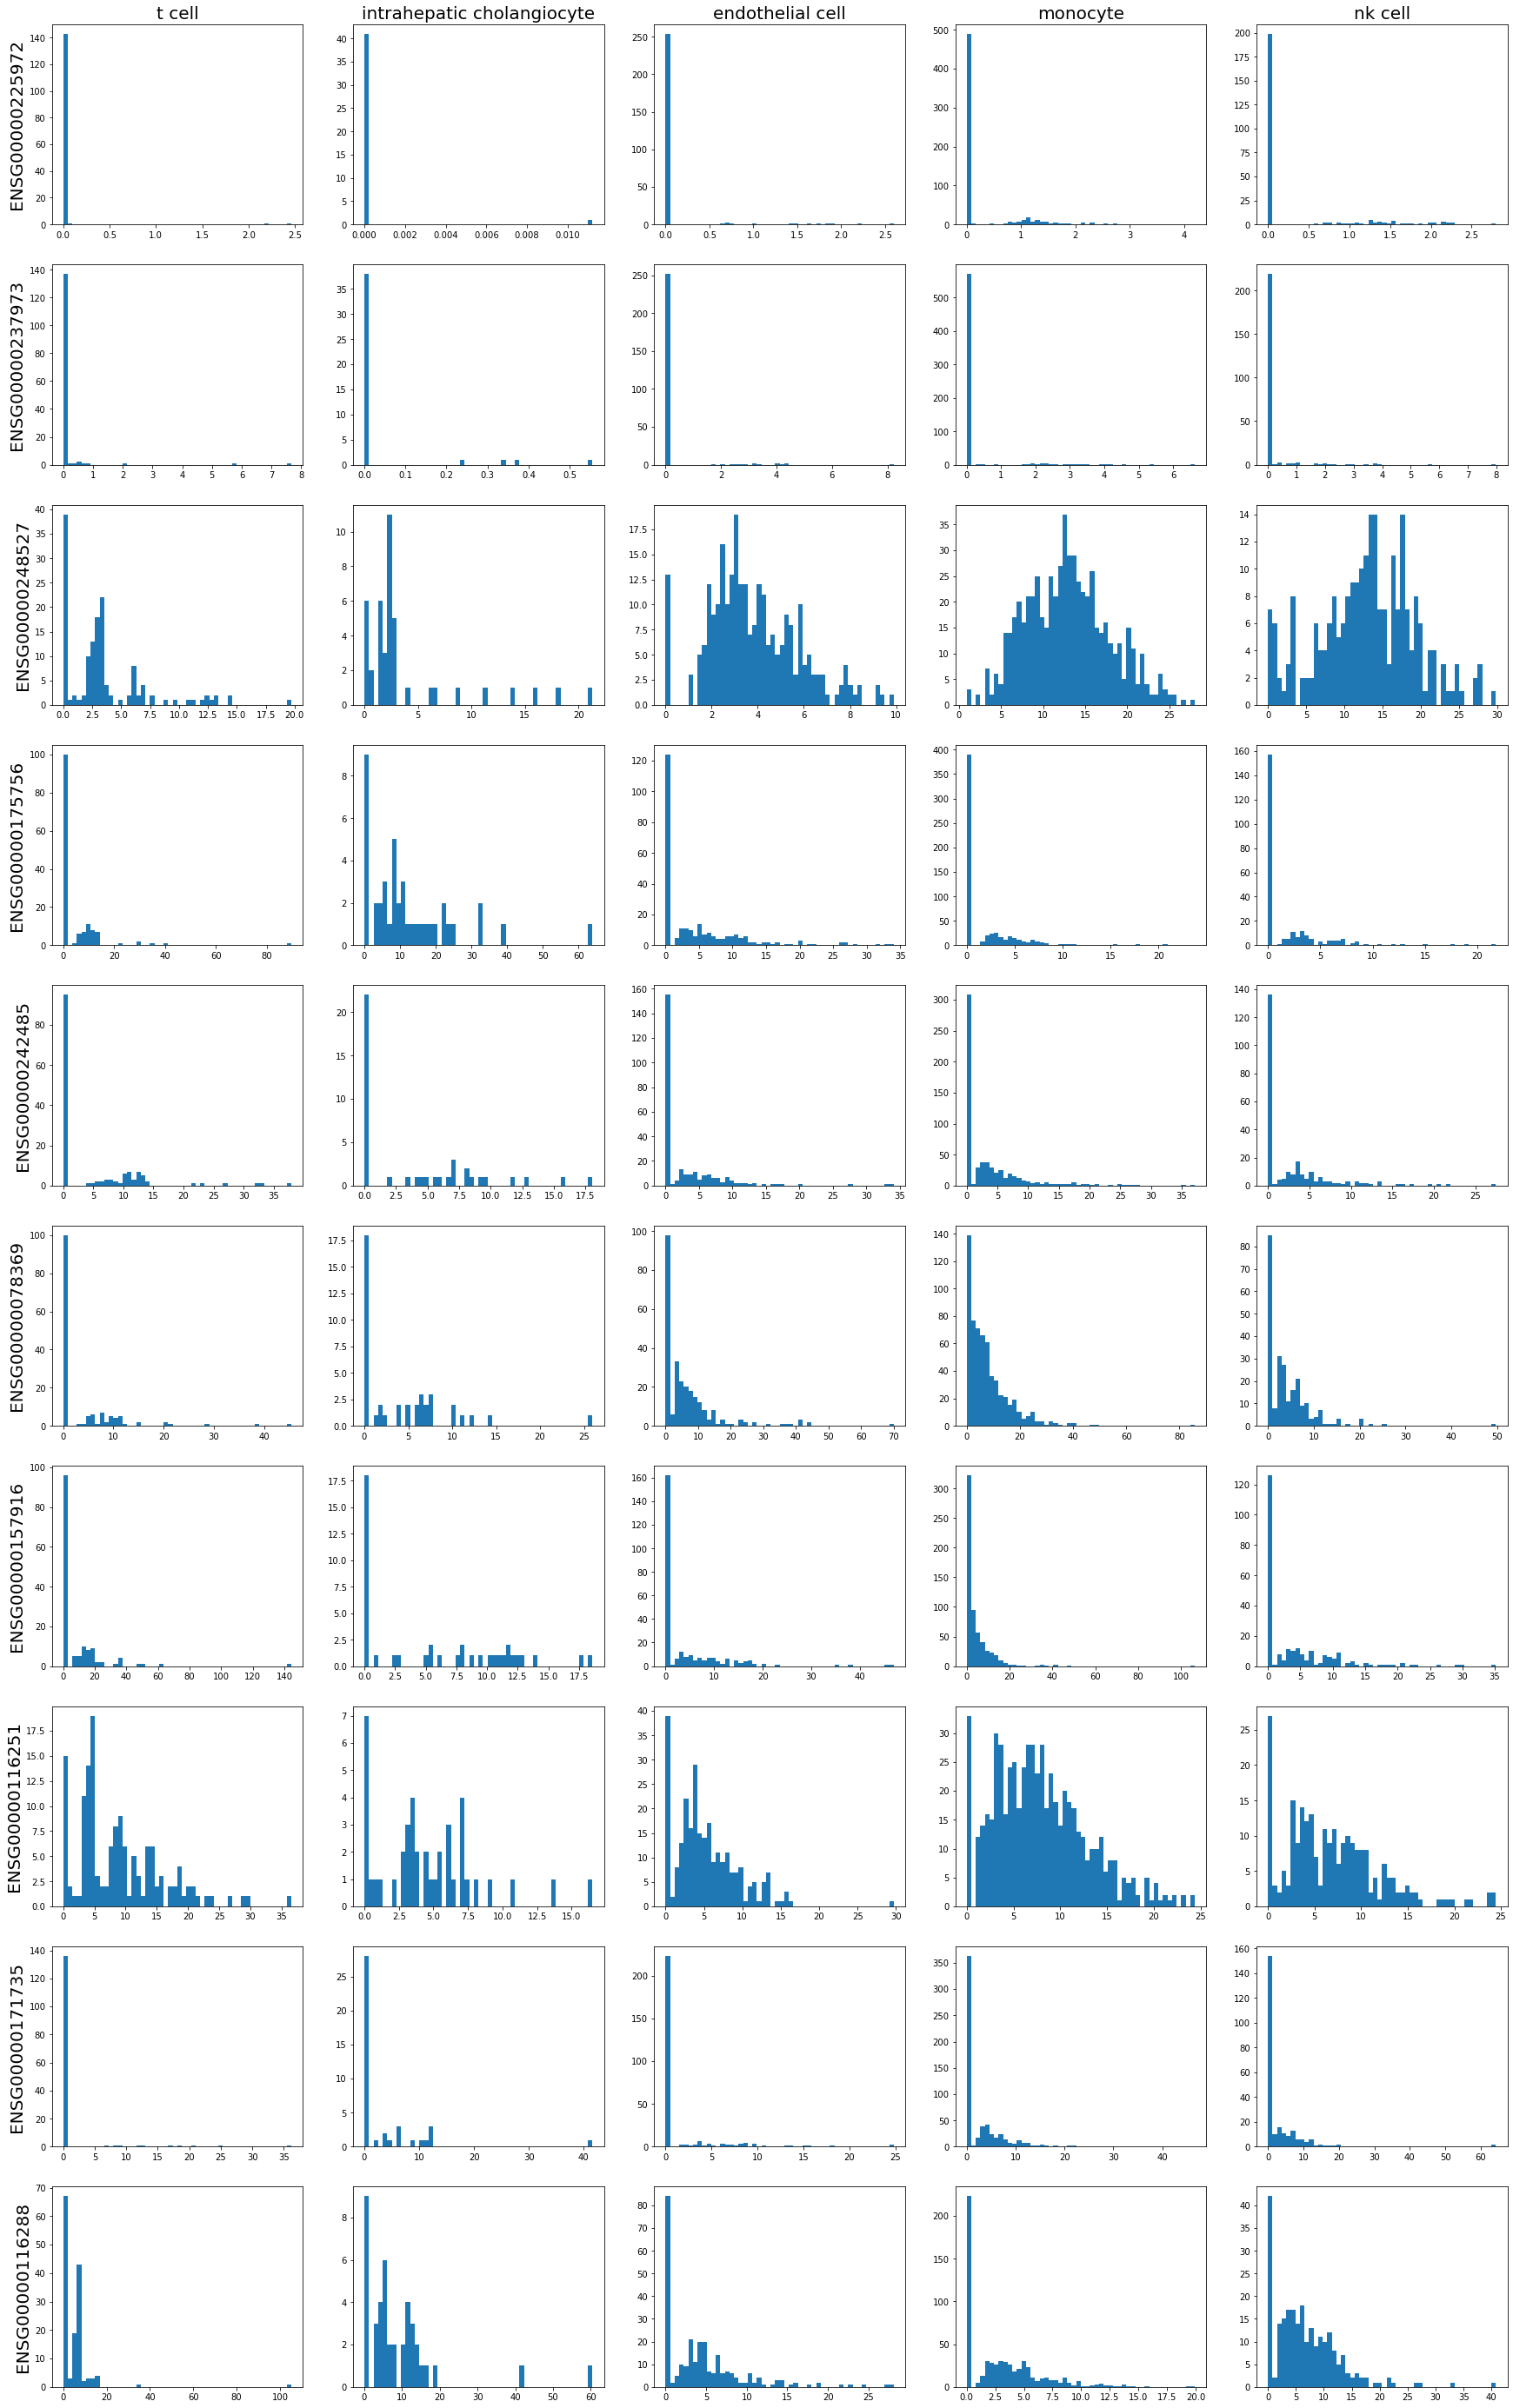

<Figure size 432x288 with 0 Axes>

In [75]:
#create 5x10 grid of subplots
fig, axes = plt.subplots(10, 5)

cell_types = agg_tissue_df.index.to_list()
genes = agg_tissue_df.columns.tolist()

#iterate over cell types and genes to create histograms
for i, gene in enumerate(genes):
    for j, cell_type in enumerate(cell_types):
        ax = axes[i, j]
        values = agg_tissue_df.loc[cell_type, gene]
        ax.hist(values, bins = 50)

#label gene names at the top of the grid subplots
for j, cell_type in enumerate(cell_types):
    axes[0, j].set_title(cell_type, fontsize = 20)
    
#label cell type names at the left of the plots
for i, gene in enumerate(genes):
    axes[i, 0].set_ylabel(gene, fontsize = 20)
    
#set figure height and width
fig.set_figheight(50)
fig.set_figwidth(30)
    
#show or save the plot as desired
plt.show()

#save plot manually from separate tab

# 11. Developing new average metric for counts

The KDE plots are useful for identifying the best median/mode value of expression accounting for the zero expression seen in many cells however it is computationally complex and would not bode well over millions of values therefore a more simple metric is required.

Most distributions are unimodal and don't appear to blend with the zero count expressions meaning there is a visible gap between the zero count expression and the rest of the distribution.

## 11.1 Read in tabula data and convert to dense

In [2]:
#read in pandas (sparse column) dataframe with cells annotated by tissue and cell type
tabula = pd.read_pickle('tabula_counts_tissue_sparse.pkl', compression = 'gzip')

In [3]:
tabula

tissue                             cell_type  ENSG00000223972  \
0       UBERON:0002107                            macrophage              0.0   
1       UBERON:0002107                              monocyte              0.0   
2       UBERON:0002107  endothelial cell of hepatic sinusoid              0.0   
3       UBERON:0002107                            macrophage              0.0   
4       UBERON:0002107                  liver dendritic cell              0.0   
...                ...                                   ...              ...   
483147  UBERON:0000947                      endothelial cell              0.0   
483148  UBERON:0000947                      endothelial cell              0.0   
483149  UBERON:0000947                      endothelial cell              0.0   
483150  UBERON:0000947                      endothelial cell              0.0   
483151  UBERON:0000947                      endothelial cell              0.0   

        ENSG00000227232  ENSG00000278267  ENSG00000243485  ENSG00000237613  \
0              0.000000              0.0              0.0              0.0   
1              0.000000              0.0              0.0              0.0   
2              0.000000              0.0              0.0              0.0   
3              0.000000              0.0              0.0              0.0   
4              0.000000              0.0              0.0              0.0   
...                 ...              ...              ...              ...   
483147         0.000000              0.0              0.0              0.0   
483148         0.000000              0.0              0.0              0.0   
483149         0.000000              0.0              0.0              0.0   
483150     22025.464844              0.0              0.0              0.0   
483151         0.000000              0.0              0.0              0.0   

        ENSG00000268020  ENSG00000240361  ENSG00000186092  ...  \
0                   0.0              0.0              0.0  ...   
1                   0.0              0.0              0.0  ...   
2                   0.0              0.0              0.0  ...   
3                   0.0              0.0              0.0  ...   
4                   0.0              0.0              0.0  ...   
...                 ...              ...              ...  ...   
483147              0.0              0.0              0.0  ...   
483148              0.0              0.0              0.0  ...   
483149              0.0              0.0              0.0  ...   
483150              0.0              0.0              0.0  ...   
483151              0.0              0.0              0.0  ...   

        ENSG00000198886  ENSG00000210176  ENSG00000210184  ENSG00000210191  \
0             90.290840              0.0              0.0              0.0   
1             88.436073              0.0              0.0              0.0   
2             99.664101              0.0              0.0              0.0   
3             76.020004              0.0              0.0              0.0   
4             84.088768              0.0              0.0              0.0   
...                 ...              ...              ...              ...   
483147        30.683167              0.0              0.0              0.0   
483148        72.125992              0.0              0.0              0.0   
483149        19.729446              0.0              0.0              0.0   
483150        10.089444              0.0              0.0              0.0   
483151        40.085453              0.0              0.0              0.0   

        ENSG00000198786  ENSG00000198695  ENSG00000210194  ENSG00000198727  \
0             20.458338         4.670524              0.0       103.710594   
1             19.309458         0.000000              0.0       132.029144   
2             45.157948         2.046921              0.0       108.283028   
3             18.596909         0.000000              0.0       

In [3]:
tabula.set_index(['tissue', 'cell_type'], inplace = True)

In [4]:
tabula_dense = tabula.sparse.to_dense()

In [ ]:
#can't run this too slow
tabula_dense.to_pickle('tabula_dense_tissue_ensemblid.pkl', compression = 'gzip')

## 11.2 Define average_metric function

In [6]:
#define minimum expression threshold for counts
MIN_EXPRESSION_THRESHOLD = 1
    
#define minimum number of observations to calculate median metric
MIN_OBSERVED_THRESHOLD = 10

def average_metric(df):
    
    # Set all values < expression threshold, including zeroes, to nan.
    df[df < MIN_EXPRESSION_THRESHOLD] = np.nan
    
    # Compute median expression values for all genes.
    median = df.median()
    
    # Filter out genes where we have too few observations.
    observation_mask = (~ df.isna()).sum() < MIN_OBSERVED_THRESHOLD
    median[observation_mask] = np.nan
    
    return median

In [ ]:
#this takes too long to run
median_tabula = tabula.groupby(['tissue', 'cell_type'], observed = True).agg(average_metric)
median_tabula

## 11.3 Run process through pandarallel

Running the function by grouping by tissue and cell type and aggregating by the function is a very slow process and thus for computational efficiency I can run the aggregation through pandarallel that parallelises the apply function. However, in order to do this need to use multi-indexing.

In [7]:
from pandarallel import pandarallel
import multiprocessing
pandarallel.initialize(progress_bar=True, nb_workers=multiprocessing.cpu_count())

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
%%time
median_tabula_counts = tabula_dense.groupby(['tissue', 'cell_type'], observed=True).parallel_apply(average_metric)
median_tabula_counts

CPU times: user 2min 5s, sys: 3min 3s, total: 5min 8s
Wall time: 7min 17s


ENSG00000223972  ENSG00000227232  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000278267  ENSG00000243485  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000237613  ENSG00000268020  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000240361  ENSG00000186092  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

In [9]:
median_tabula_counts.to_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

## 11.4 How many genes have NaN expression across all cell types?

In [12]:
tabula_median = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

In [14]:
#remove columns where all the values are NaN
tabula_median.dropna(axis = 1, how = 'all')

ENSG00000227232  ENSG00000238009  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000233750  ENSG00000268903  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000269981  ENSG00000241860  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000241599  ENSG00000279457  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

Since 39,431 genes remain this means that from our metric 17,611 genes were dropped. This is compared to 14,225 genes retained when we dropped the zero median expression counts showing that our metric is less affected by the zero counts.

## 11.5 Comparison of average_metric medians vs KDE derived medians

In [10]:
tabula_median = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

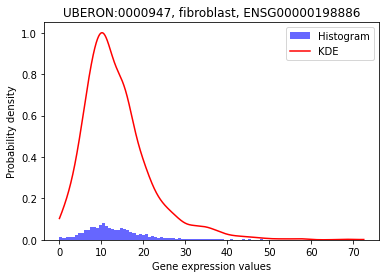

10.144010959476075


In [90]:
#kde median
gene_kde_plot('UBERON:0000947', 'fibroblast', 'ENSG00000198886')

In [9]:
#dataframe median
tabula[(tabula.tissue == 'UBERON:0000947') & (tabula.cell_type == 'fibroblast')]['ENSG00000198886'].sparse.to_dense().median()

12.168359756469727

In [16]:
#average metric median
tabula_median.loc['UBERON:0000947', 'fibroblast']['ENSG00000198886']

12.234655

Our average metric function produces a similar number to the median of the values however this is because we use the median on values exceeding 1 CPM so this is to be expected. Here, the average_metric does not make much difference since the majority of the counts are above 0 so we need to check for tissue/cell-type/genes where the zero counts expression dominates.

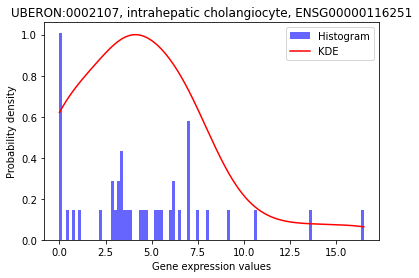

4.1230493761656435


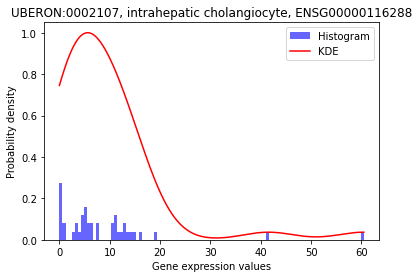

5.616901882983099


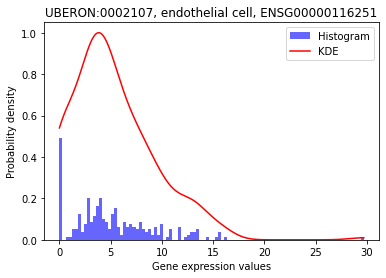

3.8348683054798403


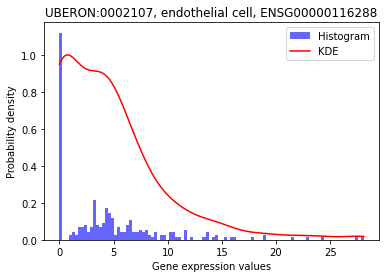

0.7501861899599384


In [23]:
for i in ['intrahepatic cholangiocyte', 'endothelial cell']:
    for j in ['ENSG00000116251', 'ENSG00000116288']:
        gene_kde_plot('UBERON:0002107', i, j)

In [27]:
#dataframe medians
for i in ['intrahepatic cholangiocyte', 'endothelial cell']:
    for j in ['ENSG00000116251', 'ENSG00000116288']:
        median = tabula[(tabula.tissue == 'UBERON:0002107') & (tabula.cell_type == i)][j].sparse.to_dense().median()
        
        print(f'The median of {i}, {j} is {median}')

The median of intrahepatic cholangiocyte, ENSG00000116251 is 3.80285382270813
The median of intrahepatic cholangiocyte, ENSG00000116288 is 5.689934730529785
The median of endothelial cell, ENSG00000116251 is 4.31837272644043
The median of endothelial cell, ENSG00000116288 is 3.5042498111724854


In [30]:
#average_metric medians
for i in ['intrahepatic cholangiocyte', 'endothelial cell']:
    for j in ['ENSG00000116251', 'ENSG00000116288']:
        median = tabula_median.loc['UBERON:0002107', i][j]
        
        print(f'The average_metric median of {i}, {j} is {median}')

The average_metric median of intrahepatic cholangiocyte, ENSG00000116251 is 5.243683338165283
The average_metric median of intrahepatic cholangiocyte, ENSG00000116288 is 7.778623580932617
The average_metric median of endothelial cell, ENSG00000116251 is 5.1393327713012695
The average_metric median of endothelial cell, ENSG00000116288 is 4.973021507263184


We see that the average metric has higher medians for this selection of cell-types and genes since it has a cutoff threshold of 1 CPM so helps to capture the non-zero counts that cells have.

# 12. Mitochondrial-encoded genes
## 12.1 Access list of mitochonrial-encoded genes from ENSEMBL

In [2]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()
gene_to_ensemblid

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Gene stable ID  Gene name
0      ENSG00000210049      MT-TF
1      ENSG00000211459    MT-RNR1
2      ENSG00000210077      MT-TV
3      ENSG00000210082    MT-RNR2
4      ENSG00000209082     MT-TL1
...                ...        ...
70110  ENSG00000252417  RNU7-179P
70111  ENSG00000236500     CD24P1
70112  ENSG00000197312       DDI2
70113  ENSG00000215695     RSC1A1
70115  ENSG00000116786    PLEKHM2

[47776 rows x 2 columns]

In [3]:
#subset out genes that contain MT- in their gene name
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Gene name'].str.contains('MT-')]
mt_genes

Gene stable ID    Gene name
0      ENSG00000210049        MT-TF
1      ENSG00000211459      MT-RNR1
2      ENSG00000210077        MT-TV
3      ENSG00000210082      MT-RNR2
4      ENSG00000209082       MT-TL1
5      ENSG00000198888       MT-ND1
6      ENSG00000210100        MT-TI
7      ENSG00000210107        MT-TQ
8      ENSG00000210112        MT-TM
9      ENSG00000198763       MT-ND2
10     ENSG00000210117        MT-TW
11     ENSG00000210127        MT-TA
12     ENSG00000210135        MT-TN
13     ENSG00000210140        MT-TC
14     ENSG00000210144        MT-TY
15     ENSG00000198804       MT-CO1
16     ENSG00000210151       MT-TS1
17     ENSG00000210154        MT-TD
18     ENSG00000198712       MT-CO2
19     ENSG00000210156        MT-TK
20     ENSG00000228253      MT-ATP8
21     ENSG00000198899      MT-ATP6
22     ENSG00000198938       MT-CO3
23     ENSG00000210164        MT-TG
24     ENSG00000198840       MT-ND3
25     ENSG00000210174        MT-TR
26     ENSG00000212907      MT-ND4L
27     ENSG00000198886       MT-ND4
28     ENSG00000210176        MT-TH
29     ENSG00000210184       MT-TS2
30     ENSG00000210191       MT-TL2
31     ENSG00000198786       MT-ND5
32     ENSG00000198695       MT-ND6
33     ENSG00000210194        MT-TE
34     ENSG00000198727       MT-CYB
35     ENSG00000210195        MT-TT
36     ENSG00000210196        MT-TP
45883  ENSG00000254959  INMT-MINDY4
69749  ENSG00000225077      ICMT-DT

In [8]:
#remove the last two genes that are not mitochondrial-encoded genes
mt_genes = mt_genes[0:-2]

#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

**Searching for MT genes using the knowledge that they exist on the MT chromosome: more efficient**

In [8]:
import pybiomart

#access dataset from ensembl
dataset = pybiomart.Dataset(name = 'hsapiens_gene_ensembl', host = 'http://www.ensembl.org')

#query Homo sapiens dataset for ensemblid and gene name
gene_to_ensemblid = dataset.query(attributes = ['ensembl_gene_id', 'external_gene_name', 'chromosome_name'])

#drop the NA values for ensemblids without a gene name
gene_to_ensemblid = gene_to_ensemblid.dropna()
gene_to_ensemblid

Gene stable ID  Gene name Chromosome/scaffold name
0      ENSG00000210049      MT-TF                       MT
1      ENSG00000211459    MT-RNR1                       MT
2      ENSG00000210077      MT-TV                       MT
3      ENSG00000210082    MT-RNR2                       MT
4      ENSG00000209082     MT-TL1                       MT
...                ...        ...                      ...
70110  ENSG00000252417  RNU7-179P                        1
70111  ENSG00000236500     CD24P1                        1
70112  ENSG00000197312       DDI2                        1
70113  ENSG00000215695     RSC1A1                        1
70115  ENSG00000116786    PLEKHM2                        1

[47776 rows x 3 columns]

In [9]:
#subset out genes that are present on MT chromosome
mt_genes = gene_to_ensemblid[gene_to_ensemblid['Chromosome/scaffold name'] == 'MT']
mt_genes

Gene stable ID Gene name Chromosome/scaffold name
0   ENSG00000210049     MT-TF                       MT
1   ENSG00000211459   MT-RNR1                       MT
2   ENSG00000210077     MT-TV                       MT
3   ENSG00000210082   MT-RNR2                       MT
4   ENSG00000209082    MT-TL1                       MT
5   ENSG00000198888    MT-ND1                       MT
6   ENSG00000210100     MT-TI                       MT
7   ENSG00000210107     MT-TQ                       MT
8   ENSG00000210112     MT-TM                       MT
9   ENSG00000198763    MT-ND2                       MT
10  ENSG00000210117     MT-TW                       MT
11  ENSG00000210127     MT-TA                       MT
12  ENSG00000210135     MT-TN                       MT
13  ENSG00000210140     MT-TC                       MT
14  ENSG00000210144     MT-TY                       MT
15  ENSG00000198804    MT-CO1                       MT
16  ENSG00000210151    MT-TS1                       MT
17  ENSG00000210154     MT-TD                       MT
18  ENSG00000198712    MT-CO2                       MT
19  ENSG00000210156     MT-TK                       MT
20  ENSG00000228253   MT-ATP8                       MT
21  ENSG00000198899   MT-ATP6                       MT
22  ENSG00000198938    MT-CO3                       MT
23  ENSG00000210164     MT-TG                       MT
24  ENSG00000198840    MT-ND3                       MT
25  ENSG00000210174     MT-TR                       MT
26  ENSG00000212907   MT-ND4L                       MT
27  ENSG00000198886    MT-ND4                       MT
28  ENSG00000210176     MT-TH                       MT
29  ENSG00000210184    MT-TS2                       MT
30  ENSG00000210191    MT-TL2                       MT
31  ENSG00000198786    MT-ND5                       MT
32  ENSG00000198695    MT-ND6                       MT
33  ENSG00000210194     MT-TE                       MT
34  ENSG00000198727    MT-CYB                       MT
35  ENSG00000210195     MT-TT                       MT
36  ENSG00000210196     MT-TP                       MT

In [10]:
#get list of ensemblid for mitchondrial-encoded genes
mt_encoded_genes = mt_genes['Gene stable ID'].to_list()

## 12.2 Search Tabula Sapiens for mitochondrial-encoded genes

In [5]:
tabula = sc.read_h5ad('tabula_sapiens_all_cells.h5ad')
tabula.var.filter(items = mt_encoded_genes, axis = 0)

feature_type  highly_variable     means  dispersions  \
ensemblid                                                                  
ENSG00000210049  Gene Expression            False  0.007144     1.878539   
ENSG00000211459  Gene Expression            False  4.580986     5.332270   
ENSG00000210077  Gene Expression            False  0.212312     1.397942   
ENSG00000210082  Gene Expression            False  5.600650     6.355399   
ENSG00000209082  Gene Expression            False  0.059871     2.182837   
ENSG00000198888  Gene Expression            False  3.540140     4.105647   
ENSG00000210100  Gene Expression            False  0.016011     0.404683   
ENSG00000210107  Gene Expression            False  0.020427     0.575981   
ENSG00000210112  Gene Expression            False  0.160283     0.935489   
ENSG00000198763  Gene Expression            False  3.482217     4.073226   
ENSG00000210117  Gene Expression            False  0.004593     0.443947   
ENSG00000210127  Gene Expression            False  0.100414     0.911829   
ENSG00000210135  Gene Expression            False  0.068116     0.960582   
ENSG00000210140  Gene Expression            False  0.060890     0.926997   
ENSG00000210144  Gene Expression            False  0.006550     0.947804   
ENSG00000198804  Gene Expression            False  4.773193     5.149180   
ENSG00000210151  Gene Expression            False  0.006895     0.416014   
ENSG00000210154  Gene Expression            False  0.058570     0.897361   
ENSG00000198712  Gene Expression            False  4.732543     5.112634   
ENSG00000210156  Gene Expression            False  0.108684     0.932243   
ENSG00000228253  Gene Expression             True  1.136066     2.986227   
ENSG00000198899  Gene Expression            False  4.453925     4.713642   
ENSG00000198938  Gene Expression            False  4.765801     5.321000   
ENSG00000210164  Gene Expression            False  0.069215     1.524048   
ENSG00000198840  Gene Expression            False  4.205263     4.682669   
ENSG00000210174  Gene Expression            False  0.017134     0.597324   
ENSG00000212907  Gene Expression            False  1.961114     2.946044   
ENSG00000198886  Gene Expression            False  4.144687     4.648150   
ENSG00000210176  Gene Expression            False  0.058554     0.711857   
ENSG00000210184  Gene Expression            False  0.195372     1.158508   
ENSG00000210191  Gene Expression            False  0.011252     0.555166   
ENSG00000198786  Gene Expression            False  2.791403     3.507203   
ENSG00000198695  Gene Expression            False  0.963484     2.466404   
ENSG00000210194  Gene Expression            False  0.160067     1.603787   
ENSG00000198727  Gene Expression            False  4.367693     4.765751   
ENSG00000210195  Gene Expression            False  0.065740     0.624316   
ENSG00000210196  Gene Expression             True  0.438510     2.705558   

                 dispersions_norm      mean       std  feature_is_filtered  \
ensemblid                                                                    
ENSG00000210049          0.144868  0.004119  0.058305                False   
ENSG00000211459          1.151367  4.017002  1.111679                False   
ENSG00000210077         -0.186193  0.117211  0.347289                False   
ENSG00000210082          0.707107  5.050154  1.058804                False   
ENSG00000209082          0.354485  0.031359  0.175047                False   
ENSG00000198888         -0.230782  2.959633  1.147535                False   
ENSG00000210100         -0.870403  0.010362  0.089613                False   
ENSG00000210107         -0.752404  0.012504  0.104350                False   
ENSG00000210112         -0.504756  0.095911  0.295638                False   
ENSG00000198763         -0.248327  2.953358  1.085826                False   
ENSG00000210117         -0.843356  0.002934  0.048194                False   
ENSG00000210127         -0.521053  0.0584

The mitchondrial-encoded genes are present in the feature dataframe for the AnnData object for Tabula Sapiens. I need to check whether they also made their way into the median counts.

In [6]:
tabula = pd.read_pickle('median_exp_tabula_counts_ensemblid.pkl', compression = 'gzip')
tabula.filter(items = mt_encoded_genes, axis = 1)

ENSG00000210049  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000211459  \
tissue_in_publication cell_type                                               
Bladder               b cell                                      41.612370   
                      bladder urothelial cell                     88.159126   
                      capillary endothelial cell                  57.507015   
                      endothelial cell of lymphatic vessel        66.705288   
                      fibroblast                                  34.308380   
...                                                                     ...   
Vasculature           nk cell                                     41.513165   
                      pericyte cell                               27.790253   
                      plasma cell                                  9.177984   
                      smooth muscle cell                          20.309801   
                      t cell                                      45.920050   

                                                            ENSG00000210077  \
tissue_in_publication cell_type                                               
Bladder               b cell                                            0.0   
                      bladder urothelial cell                           0.0   
                      capillary endothelial cell                        0.0   
                      endothelial cell of lymphatic vessel              0.0   
                      fibroblast                                        0.0   
...                                                                     ...   
Vasculature           nk cell                                           0.0   
                      pericyte cell                                     0.0   
                      plasma cell                                       0.0   
                      smooth muscle cell                                0.0   
                      t cell                                            0.0   

                                                            ENSG00000210082  \
tissue_in_publication cell_type                                               
Bladder               b cell                                     122.076851   
                      bladder urothelial cell                    256.230255   
                      capillary endothelial cell                 203.081833   
                      endothelial cell of lymphatic vessel       243.471107   
                      fibroblast                                 107.549652   
...                                                                     ...   
Vasculature           nk cell                                     98.476196   
                      pericyte cell                               80.857010   
                      plasma cell                                 24.254200   
                      smooth muscle cell                          57.949753   
                      t cell

They did make their way into the median expression counts dataframe for the individual cells so we need to be mindful of this when looking at gene expression comparisons.

# 13. Final Data Output

In [6]:
tabula = pd.read_pickle('median_metric_tabula_counts.pkl', compression = 'gzip')

In [3]:
tabula

ENSG00000223972  ENSG00000227232  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000278267  ENSG00000243485  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000237613  ENSG00000268020  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000240361  ENSG00000186092  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

In [14]:
#remove columns where all the values are NaN
tabula = tabula.dropna(axis = 1, how = 'all')
tabula = tabula.reset_index()

In [15]:
tabula

tissue                    cell_type  ENSG00000227232  \
0    UBERON:0000016                       b cell              NaN   
1    UBERON:0000016             endothelial cell              NaN   
2    UBERON:0000016                    mast cell              NaN   
3    UBERON:0000016                 myeloid cell              NaN   
4    UBERON:0000016       pancreatic acinar cell              NaN   
..              ...                          ...              ...   
764  UBERON:0018707                  plasma cell              NaN   
765  UBERON:0018707  plasmacytoid dendritic cell              NaN   
766  UBERON:0018707           smooth muscle cell              NaN   
767  UBERON:0018707                       t cell              NaN   
768  UBERON:0018707        vein endothelial cell              NaN   

     ENSG00000238009  ENSG00000233750  ENSG00000268903  ENSG00000269981  \
0                NaN              NaN              NaN              NaN   
1                NaN              NaN              NaN              NaN   
2                NaN              NaN              NaN              NaN   
3                NaN              NaN              NaN              NaN   
4                NaN              NaN              NaN              NaN   
..               ...              ...              ...              ...   
764              NaN              NaN              NaN              NaN   
765              NaN              NaN              NaN              NaN   
766              NaN              NaN              NaN              NaN   
767              NaN              NaN              NaN              NaN   
768              NaN              NaN              NaN              NaN   

     ENSG00000241860  ENSG00000241599  ENSG00000279457  ...  ENSG00000198886  \
0                NaN              NaN              NaN  ...        19.339554   
1                NaN              NaN              NaN  ...        21.089552   
2                NaN              NaN              NaN  ...        26.537643   
3                NaN              NaN              NaN  ...        19.736168   
4                NaN              NaN              NaN  ...        20.173513   
..               ...              ...              ...  ...              ...   
764              NaN              NaN              NaN  ...        10.436072   
765              NaN              NaN              NaN  ...        32.792404   
766              NaN              NaN              NaN  ...        59.357460   
767              NaN              NaN              NaN  ...        28.703005   
768              NaN              NaN              NaN  ...        28.743824   

     ENSG00000210176  ENSG00000210184  ENSG00000210191  ENSG00000198786  \
0                NaN              NaN              NaN         5.395704   
1                NaN              NaN              NaN         8.993362   
2                NaN              NaN              NaN        13.669518   
3                NaN              NaN              NaN         7.315608   
4                NaN              NaN              NaN         4.997244   
..               ...              ...              ...              ...   
764              NaN              NaN              NaN         3.812207   
765              NaN              NaN              NaN        10.851281   
766              NaN         3.291515              NaN        19.427898   
767       161.340042        19.775871              NaN        10.623112   
768              NaN              NaN              NaN        12.842116   

     ENSG00000198695  ENSG00000210194  ENSG00000198727  ENSG00000210195  \
0           3.489092        13.395752        40.021950              NaN   
1           2.679963        44.480511        41.907898              NaN   
2           4.014368              NaN        60.740822              NaN   
3           4.754292         5.817049        30.588665              NaN   
4           3.565895        19.759800        2

In [16]:
tabula.to_pickle('final_tabula_adjusted_median_drop_na.pkl', compression = 'gzip')